In [1]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='fivethirtyeight')
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Loading & Inspecting Data

In [5]:
data = pd.read_csv('C:\Group-Adam\Portofolio project\Data Science Projects\Deep learning\Walmart Store Sales Prediction\Walmart.csv')


In [3]:
data.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [6]:
# some information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
# change float format in data
pd.options.display.float_format = '{:,.0f}'.format

In [7]:
# data distribution
data.describe().round(2)

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price      CPI  \
count  6435.00       6435.00       6435.00      6435.00     6435.00  6435.00   
mean     23.00    1046964.88          0.07        60.66        3.36   171.58   
std      12.99     564366.62          0.26        18.44        0.46    39.36   
min       1.00     209986.25          0.00        -2.06        2.47   126.06   
25%      12.00     553350.10          0.00        47.46        2.93   131.74   
50%      23.00     960746.04          0.00        62.67        3.44   182.62   
75%      34.00    1420158.66          0.00        74.94        3.74   212.74   
max      45.00    3818686.45          1.00       100.14        4.47   227.23   

       Unemployment  
count       6435.00  
mean           8.00  
std            1.88  
min            3.88  
25%            6.89  
50%            7.87  
75%            8.62  
max           14.31

In [ ]:
# Data Preperation

In [10]:
 # 1. Rename Columns

In [9]:
# rename columns
data.columns  = data.columns.str.lower()
data.rename({'holiday_flag': 'is_holiday'}, axis = 1, inplace = True)
data.columns

Index(['store', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

In [13]:
 # 2. Missing Values

In [10]:
# cheak missing values
data.isnull().sum()

store           0
date            0
weekly_sales    0
is_holiday      0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

In [ ]:
# Conclusion:
 # The dataset doesn't have any missing values

In [ ]:
 # 3. Duplicate Values

In [11]:
# Check Duplicate Values
data.duplicated().sum()

0

In [ ]:
# Conclusion:
  # The dataset doesn't have any duplicate values

In [ ]:
 # 4. Feature Engineering

In [12]:
def get_season(quarter):

    '''this function is to get season according to quarter column'''

    if quarter == 1:
        return 'Winter'
    elif quarter == 2:
        return 'Spring'
    elif quarter == 3:
        return 'Summer'
    else:
        return 'Autumn'

In [13]:
# correct data format of the 'date' column
data['date'] = pd.to_datetime(data['date'], format = "%d-%m-%Y")

# Create a new column "year" containing the year
data['year'] = data['date'].dt.year

# Create a new column "quarter" containing the season number
data['quarter'] = data['date'].dt.quarter

# Create a new column "season" containing the season
data['season'] = data['quarter'].apply(get_season)

# Create a new column "month" containing the month number
data['month'] = data['date'].dt.month

# Create a new column "month_name" containing the month names
data['month_name'] = data['date'].dt.month_name()

# Create a new column "week" containing the week number
data['week'] = data['date'].dt.isocalendar().week

# Create a new column "day_of_week" containing the day names
data['day_of_week'] = data['date'].dt.day_name()

In [14]:
# display a data sample
data.head(5)

store       date  weekly_sales  is_holiday  temperature  fuel_price  \
0      1 2010-02-05    1643690.90           0        42.31       2.572   
1      1 2010-02-12    1641957.44           1        38.51       2.548   
2      1 2010-02-19    1611968.17           0        39.93       2.514   
3      1 2010-02-26    1409727.59           0        46.63       2.561   
4      1 2010-03-05    1554806.68           0        46.50       2.625   

          cpi  unemployment  year  quarter  season  month month_name  week  \
0  211.096358         8.106  2010        1  Winter      2   February     5   
1  211.242170         8.106  2010        1  Winter      2   February     6   
2  211.289143         8.106  2010        1  Winter      2   February     7   
3  211.319643         8.106  2010        1  Winter      2   February     8   
4  211.350143         8.106  2010        1  Winter      3      March     9   

  day_of_week  
0      Friday  
1      Friday  
2      Friday  
3      Friday  
4      Friday

In [15]:
data['week'] = data['week'].astype('int32')

In [ ]:
# Exploratory Data Analysis (EDA):
   # 1. Univariate Analysis
   # 2. Bi-variate Analysis
   # 3. Time Series Analysis

In [ ]:
 #  Univariate Analysis:
    
    # 1. Numerical Features:
         # weekly_sales
         # temperature
         # fuel_price
         # unemployment
         # cpi
    

In [16]:
data[['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']].describe()

weekly_sales  temperature   fuel_price  unemployment          cpi
count  6.435000e+03  6435.000000  6435.000000   6435.000000  6435.000000
mean   1.046965e+06    60.663782     3.358607      7.999151   171.578394
std    5.643666e+05    18.444933     0.459020      1.875885    39.356712
min    2.099862e+05    -2.060000     2.472000      3.879000   126.064000
25%    5.533501e+05    47.460000     2.933000      6.891000   131.735000
50%    9.607460e+05    62.670000     3.445000      7.874000   182.616521
75%    1.420159e+06    74.940000     3.735000      8.622000   212.743293
max    3.818686e+06   100.140000     4.468000     14.313000   227.232807

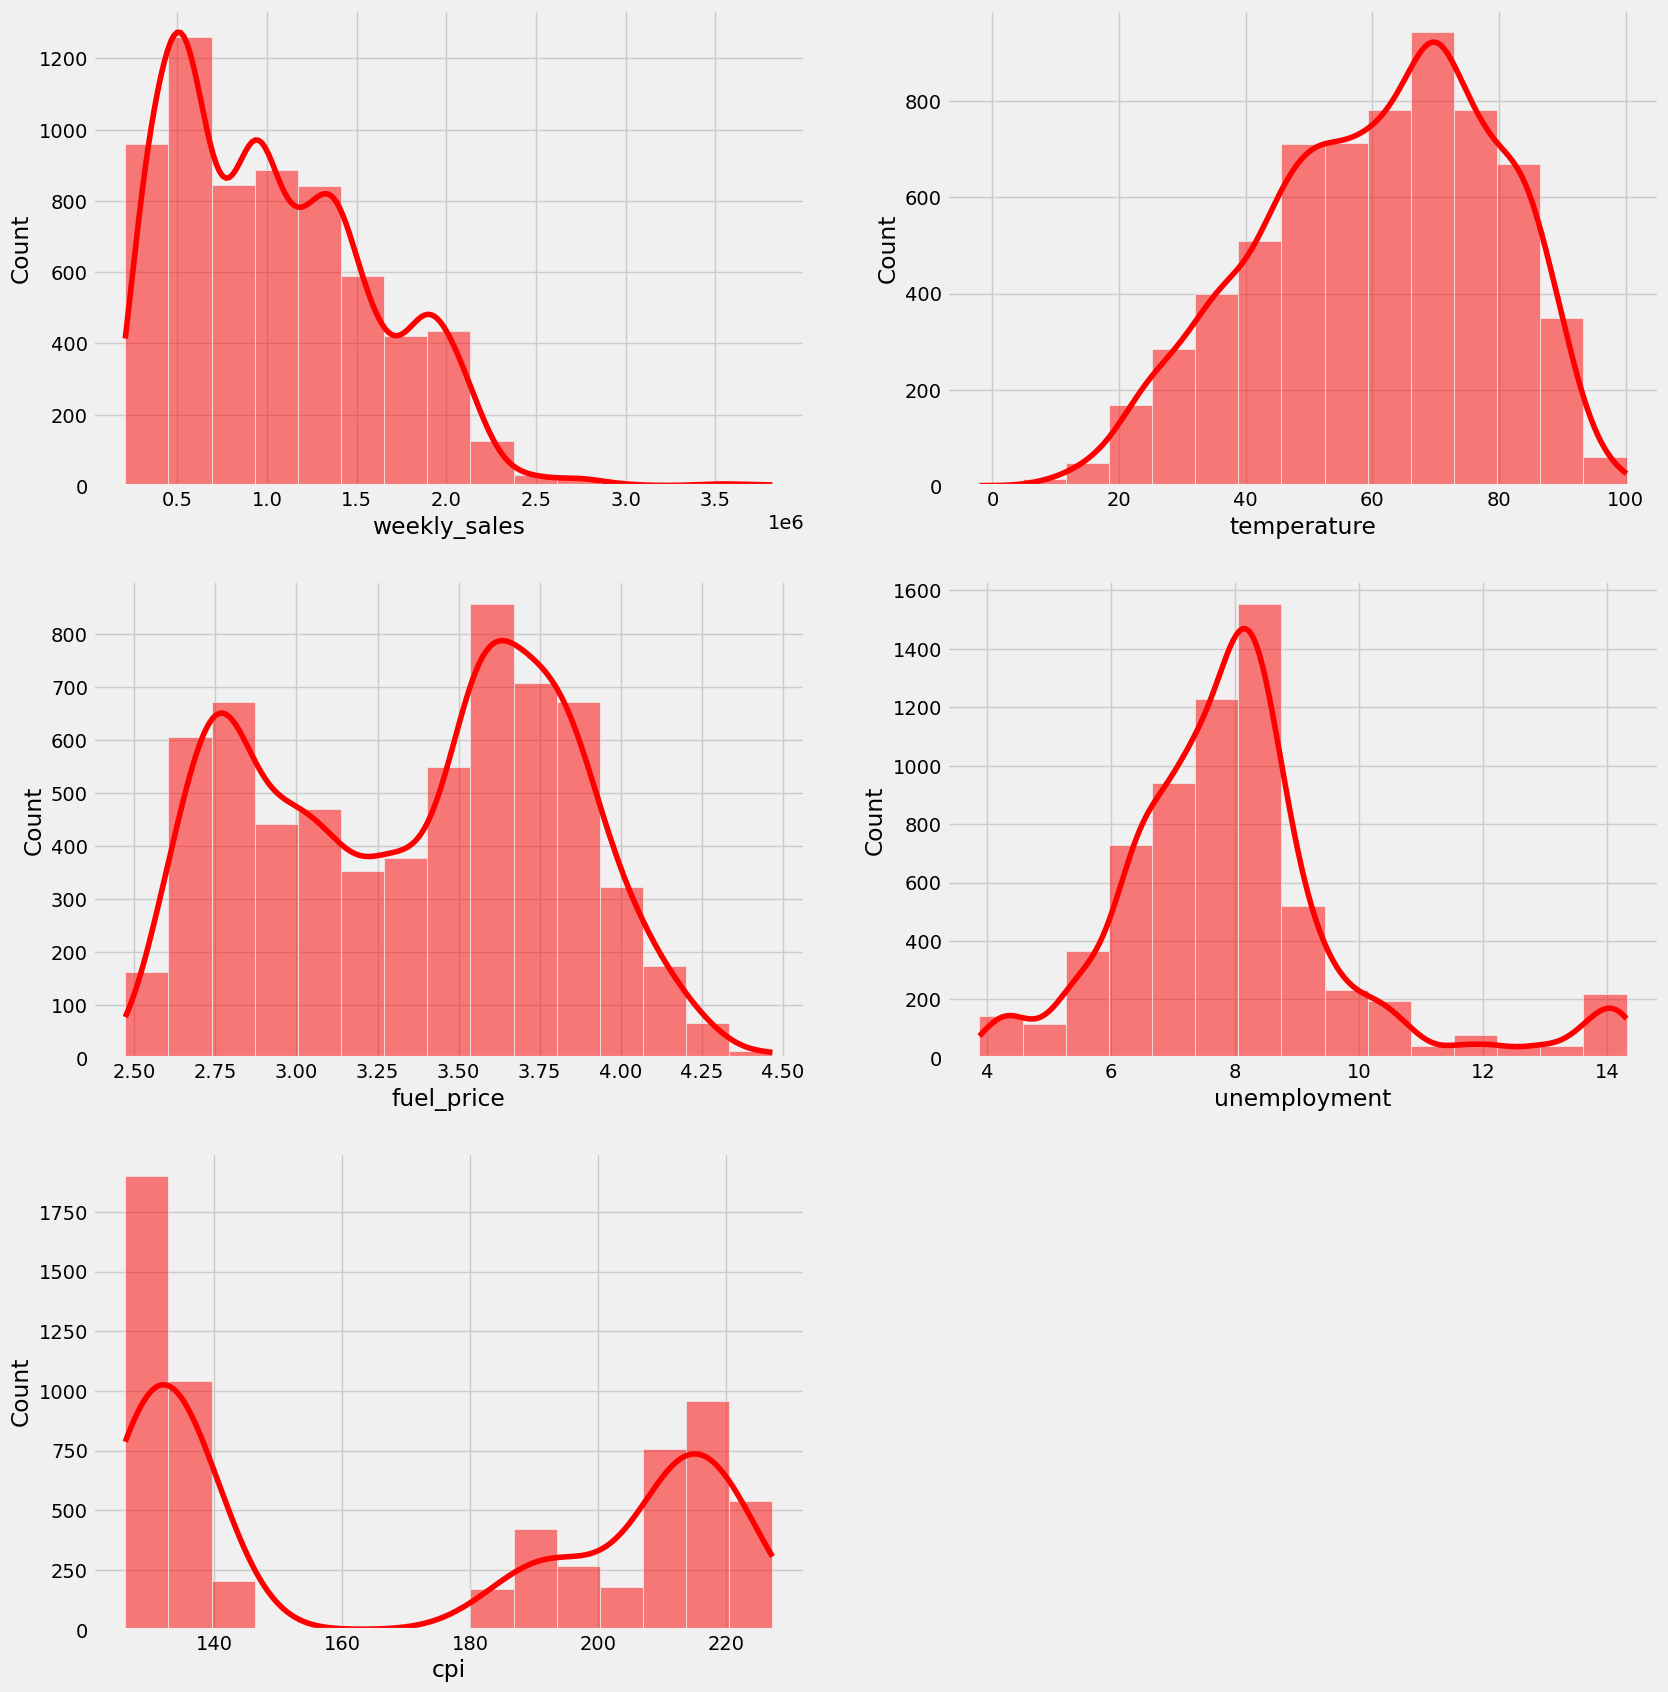

In [17]:
columns = ['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']
plt.figure(figsize=(18, 20))
for i,col in enumerate(columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'r')
plt.show()

In [ ]:
# Conclusion:

# 1. The distribution of Weekly_Sales is right skewed, this is normal because the weekly sales may be high in some time.
# 2. Temperature and Unemployment have normal distribution.
# 3. CPI and Fuel_Price have bimodal distribution.

In [ ]:
# 2. categorical Features :
 # 1.is_holiday 
 # 2. year
 # 3. season
 # 4. month_name
 # 5. day_of_week

In [ ]:
 # 2.1. is_holiday

In [18]:
d = data['is_holiday'].value_counts()
d

is_holiday
0    5985
1     450
Name: count, dtype: int64

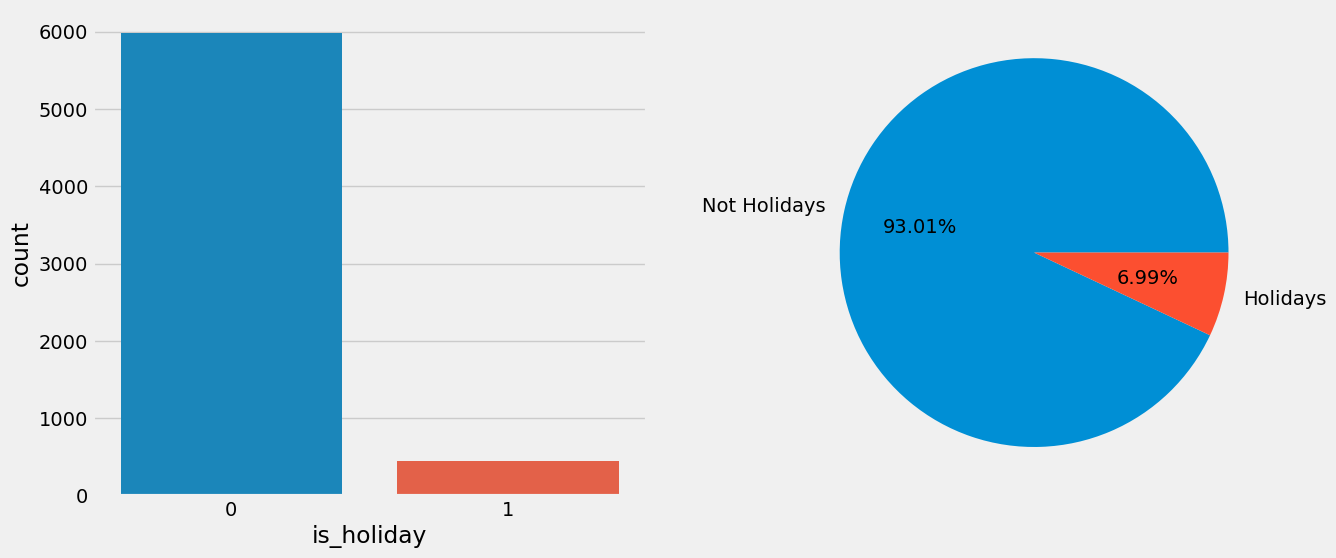

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'is_holiday', ax = ax[0])

ax[1].pie(data['is_holiday'].value_counts().values,
          labels = ['Not Holidays', 'Holidays'],
          autopct = '%1.2f%%')

plt.show()

In [ ]:
# Conclusion:

# Days of no holiday are the most frequent than days of holiday in the dataset with a percentage of 93 % and this is normal.

In [ ]:
# 2.2. year

In [20]:
data['year'].value_counts()

year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64

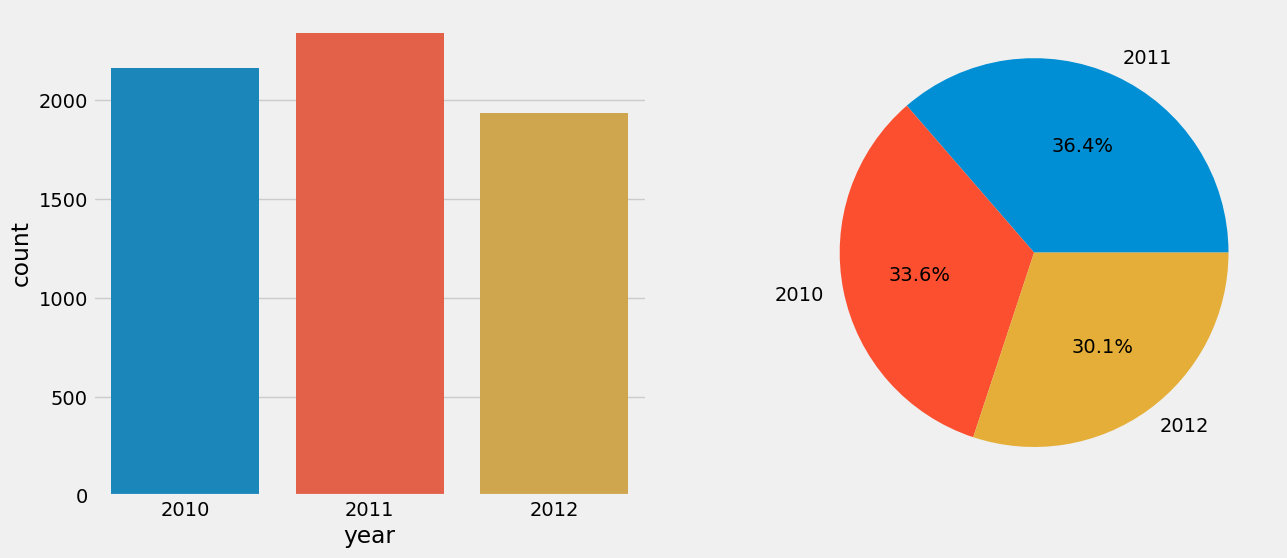

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'year', ax = ax[0])
ax[1].pie(data['year'].value_counts().values,
          labels = data['year'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

In [ ]:
# Conclusion:

# 2011 is the most frequent in the dataset because most of the weekly sales were recorded during this year.

In [ ]:
# 2.3. season

In [22]:
data['season'].value_counts()

season
Summer    1800
Spring    1755
Winter    1485
Autumn    1395
Name: count, dtype: int64

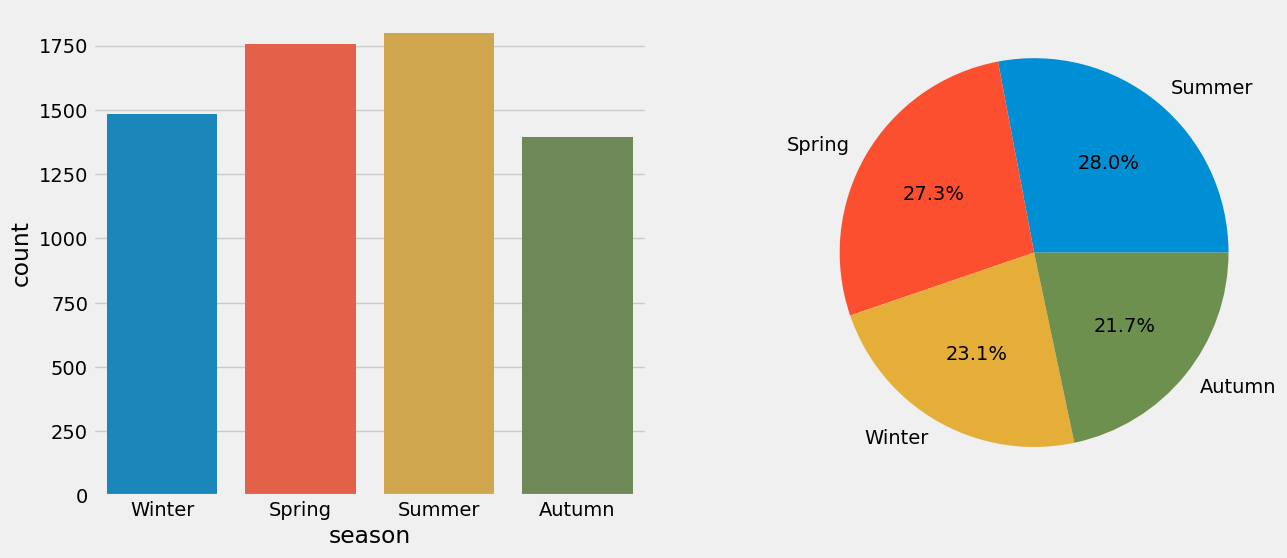

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'season', ax = ax[0])
ax[1].pie(data['season'].value_counts().values,
          labels = data['season'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

In [ ]:
# Conclusion:

# Summer is the most frequent in the dataset because most of the weekly sales were recorded during this season.

In [ ]:
# 2.4. month_name

In [24]:
data['month_name'].value_counts()

month_name
April        630
July         630
March        585
June         585
August       585
September    585
October      585
February     540
May          540
December     450
November     360
January      360
Name: count, dtype: int64

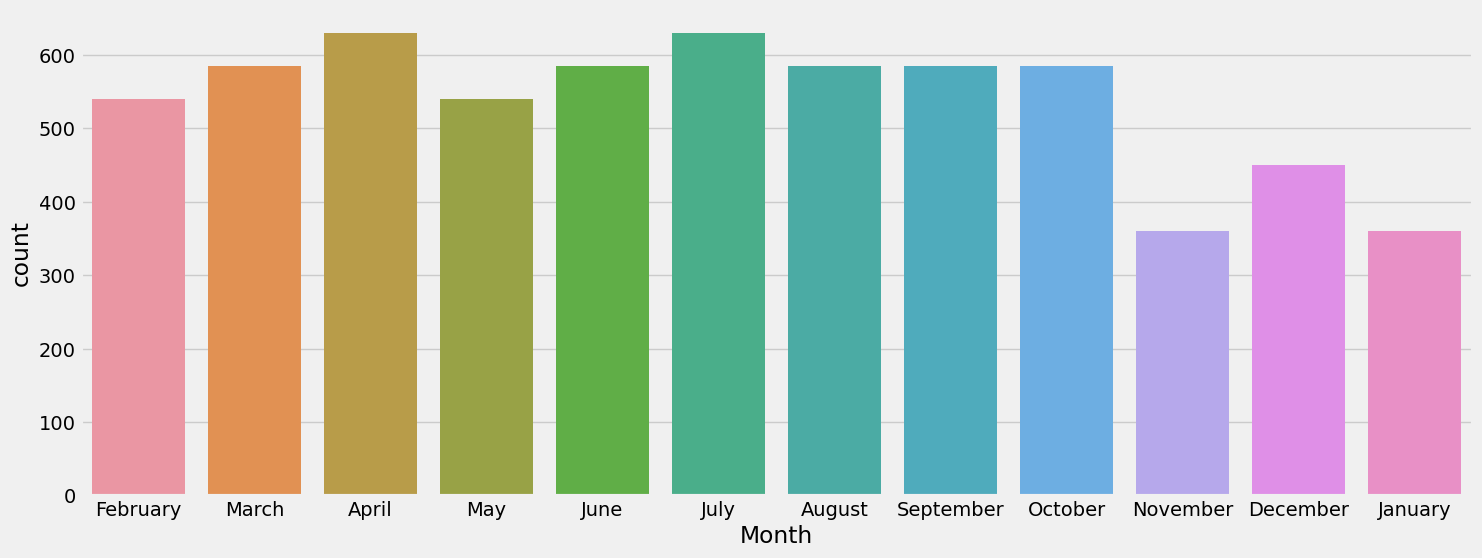

In [25]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'month_name')
plt.xlabel('Month')
plt.show()

In [ ]:
# Conclusion:

# April and July are the most frequent in the dataset because most of the weekly sales were recorded in these months.


In [ ]:
# 2.5. day_of_week

In [26]:
data['day_of_week'].value_counts()

day_of_week
Friday    6435
Name: count, dtype: int64

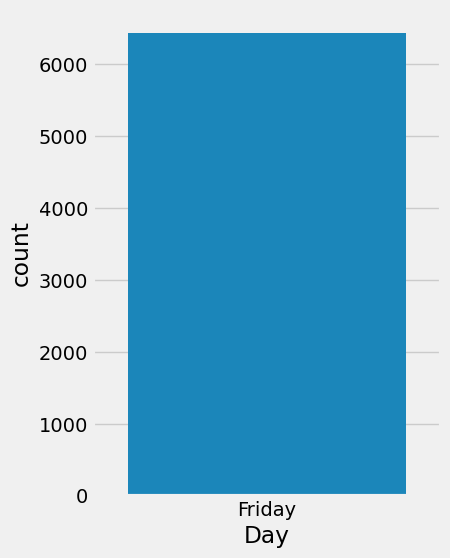

In [27]:
plt.figure(figsize=(4, 6))
sns.countplot(data = data, x = 'day_of_week')
plt.xlabel('Day')
plt.show()

In [ ]:
# Conclusion:

# Friday is frequented in each row.

In [ ]:
# 2.6. store

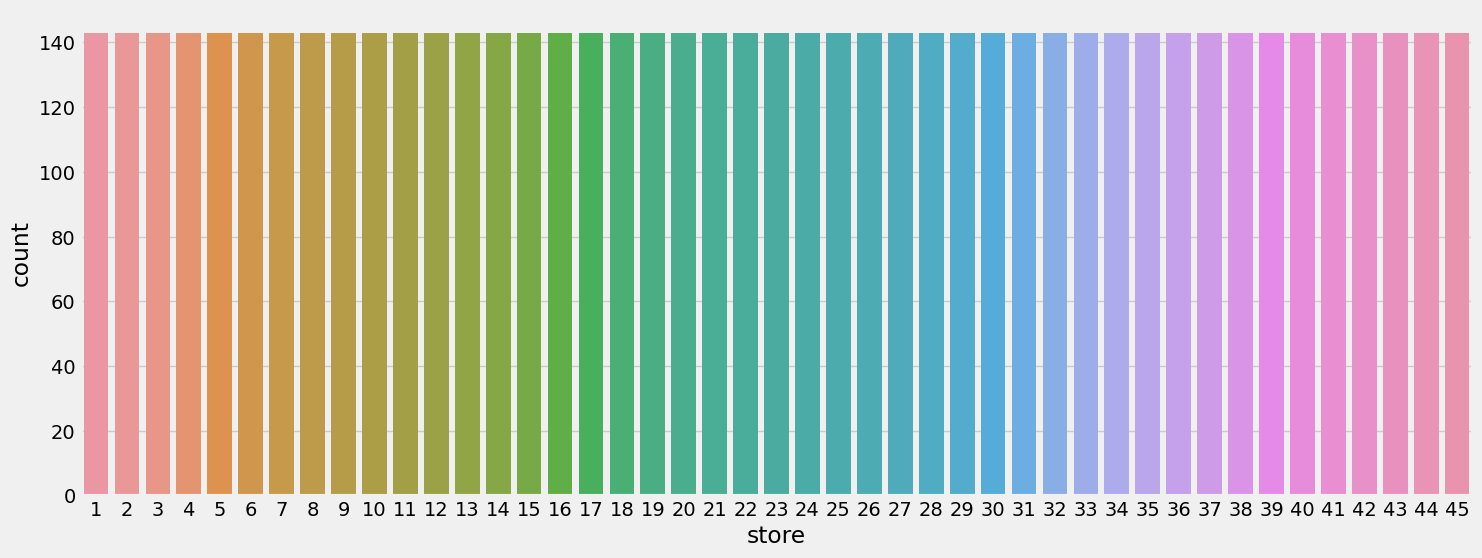

In [28]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'store')
plt.show()

In [ ]:
# Conclusion:

# All stores are frequent with the same count in the dataset.

In [ ]:
# Bi-variate Analysis:
  # 1. weekly_sales & is_holiday

In [ ]:
# Q1: What are the average sales on holidays and regular days?

In [29]:
data.groupby('is_holiday')['weekly_sales'].mean()

is_holiday
0    1.041256e+06
1    1.122888e+06
Name: weekly_sales, dtype: float64

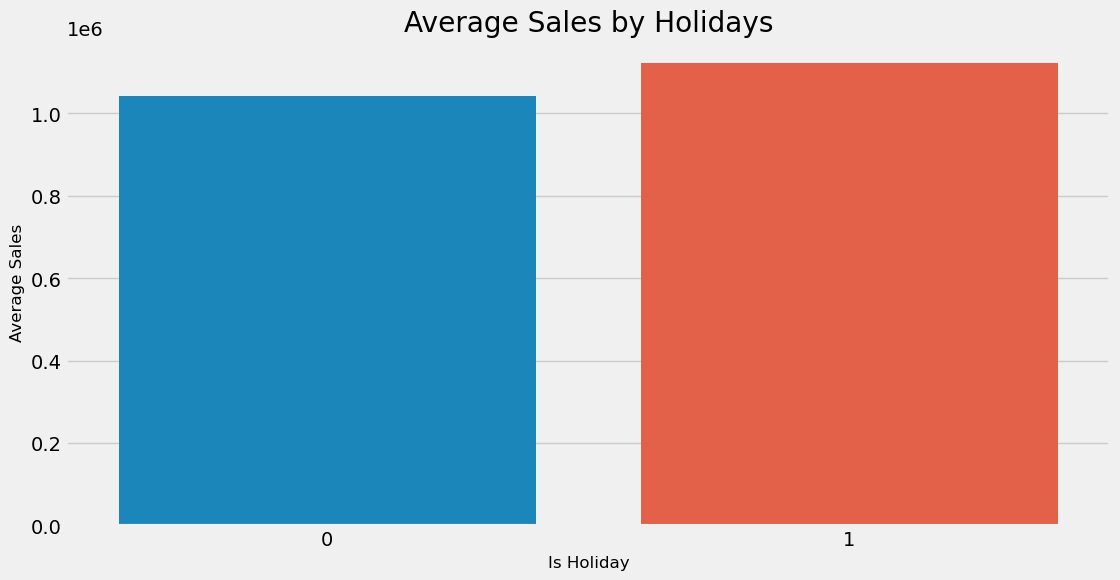

In [30]:
plt.figure(figsize = (12, 6))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.mean,
            ci = False)

# Add labels and title
plt.title('Average Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Average Sales', size = 12)
plt.show()

In [ ]:
# Conclusion:

# The rate of sales on holidays is higher than on other days.

In [ ]:
# Q2: What are the total sales on holidays and regular days?

In [31]:
data.groupby('is_holiday')['weekly_sales'].sum()

is_holiday
0    6.231919e+09
1    5.052996e+08
Name: weekly_sales, dtype: float64

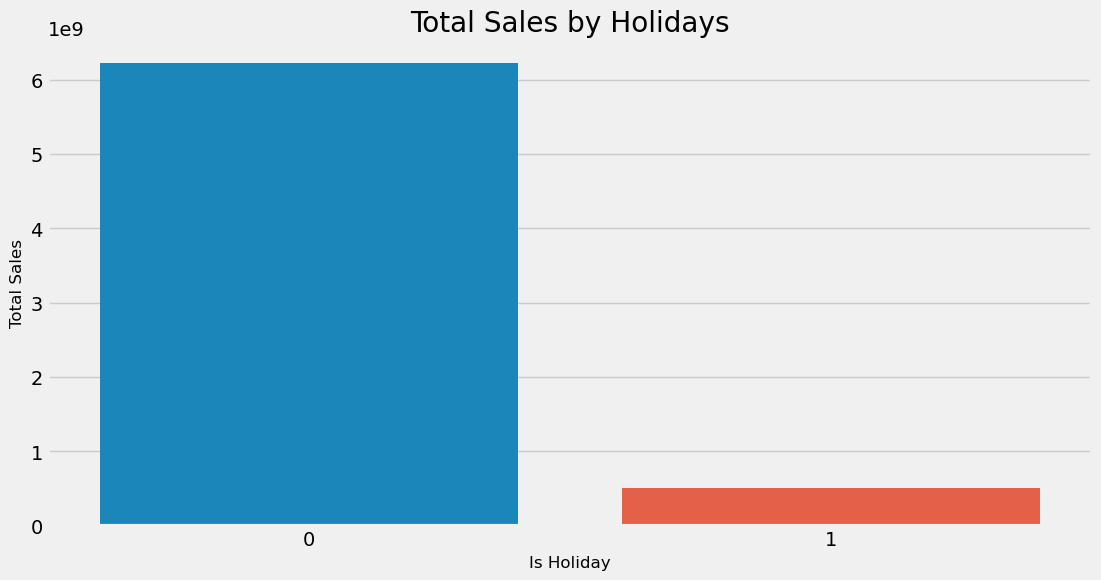

In [32]:
plt.figure(figsize = (12, 6))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Total Sales', size = 12)
plt.show()

In [ ]:
# Conclusion:

# Total sales on holidays are lower than on other days, which is normal because the number of holidays is very small compared with the number of other days.

In [ ]:
# 2. weekly_sales & store

In [ ]:
# Q3: What are the total sales in each store?

In [33]:
gb_store = data.groupby('store')['weekly_sales'].sum().sort_values(ascending = False)
gb_store

store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
19    2.066349e+08
31    1.996139e+08
23    1.987506e+08
24    1.940160e+08
11    1.939628e+08
28    1.892637e+08
41    1.813419e+08
32    1.668192e+08
18    1.551147e+08
22    1.470756e+08
12    1.442872e+08
26    1.434164e+08
34    1.382498e+08
40    1.378703e+08
35    1.315207e+08
8     1.299512e+08
17    1.277821e+08
45    1.123953e+08
21    1.081179e+08
25    1.010612e+08
43    9.056544e+07
15    8.913368e+07
7     8.159828e+07
42    7.956575e+07
9     7.778922e+07
29    7.714155e+07
16    7.425243e+07
37    7.420274e+07
30    6.271689e+07
3     5.758674e+07
38    5.515963e+07
36    5.341221e+07
5     4.547569e+07
44    4.329309e+07
33    3.716022e+07
Name: weekly_sales, dtype: float64

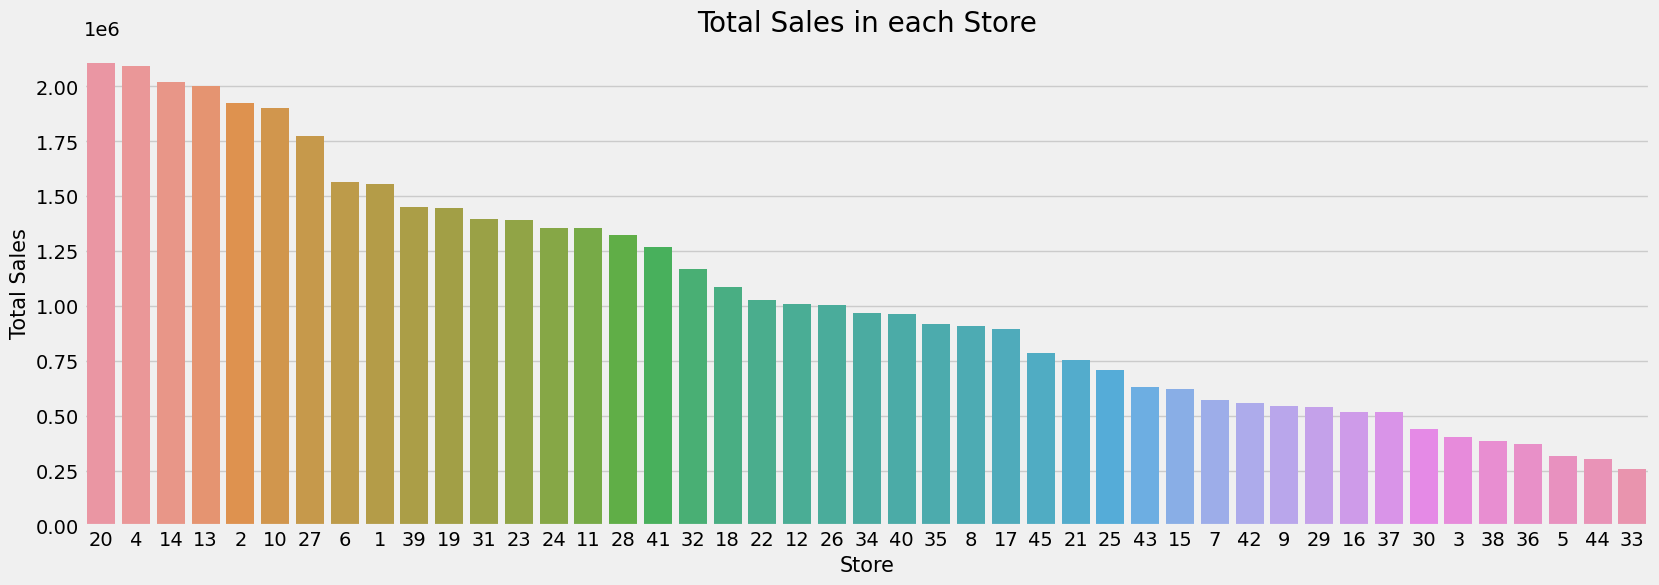

In [34]:
plt.figure(figsize = (18, 6))
sns.barplot(data = data,
            x = 'store',
            y = 'weekly_sales',
            order = gb_store.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

# There is a high variance in weekly sales from one store to another.
# Store No. 20 has the highest sales from any store with 301,397,792 followed by Store No. 4 with 299,543,953 and Store No. 33 comes last with 37,160,222$.

In [ ]:
# 3. weekly_sales & temperature

In [ ]:
# Q4: What happens to sales in the different temperatures?

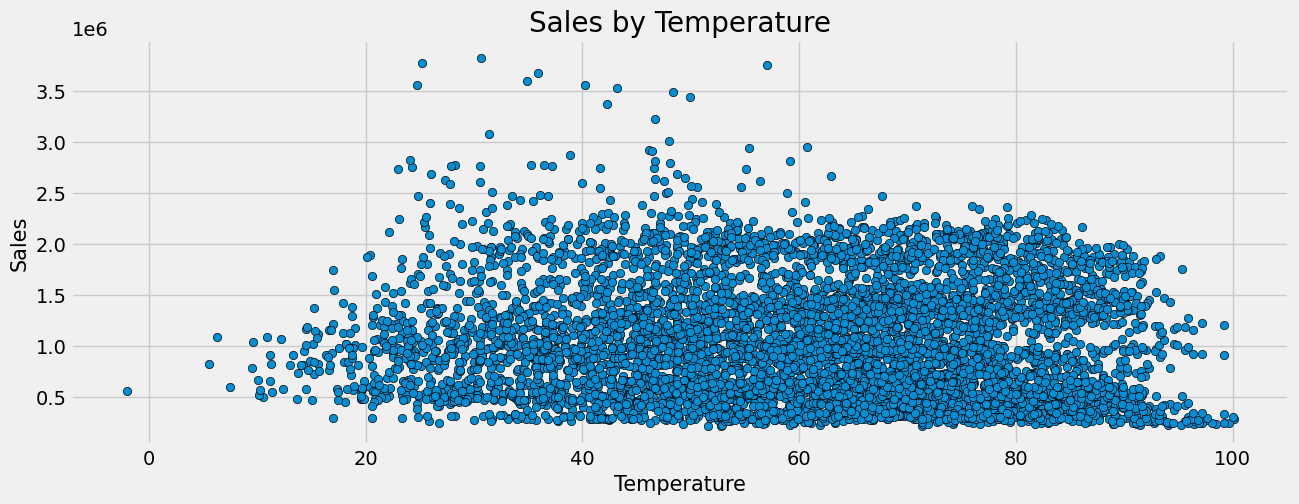

In [35]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'temperature',
                y = 'weekly_sales',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Temperature', size = 20)
plt.xlabel('Temperature', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

# Sales are not affected by changes in temperature

In [ ]:
# 4. weekly_sales & fule_price

In [ ]:
# Q5: What happens to sales with an increase in fuel price?

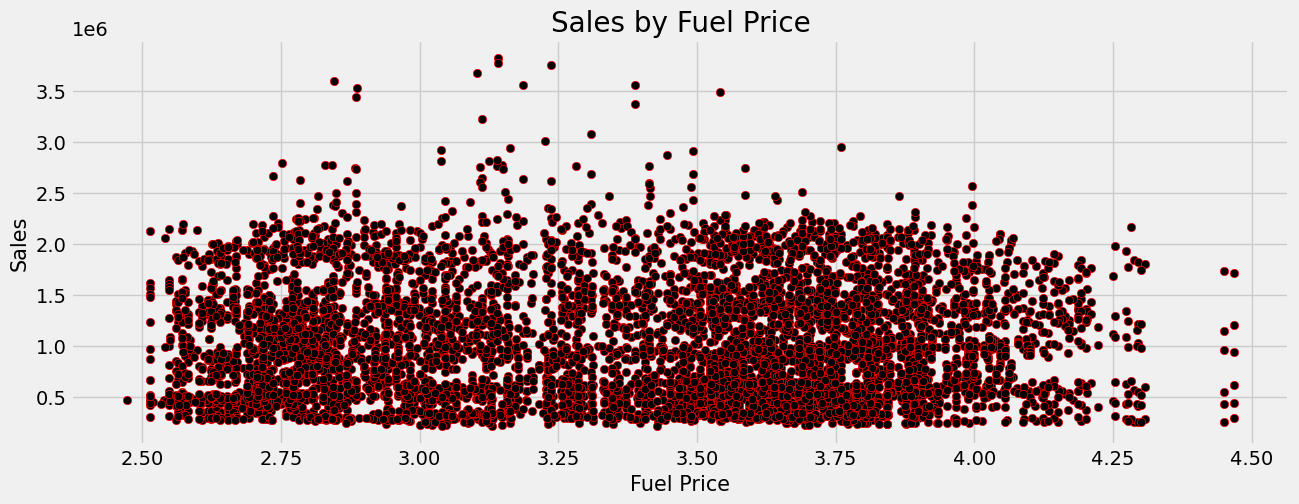

In [36]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'fuel_price',
                y = 'weekly_sales',
                color = 'black',
                edgecolor = "red")

# Add labels and title
plt.title('Sales by Fuel Price', size = 20)
plt.xlabel('Fuel Price', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

# Sales are not affected by an increase in fuel price.

In [ ]:
# 5. weekly_sales & cp

In [ ]:
# Q6: What happens to sales based on Consumer Price Index (CPI) or the consumer's economic condition?

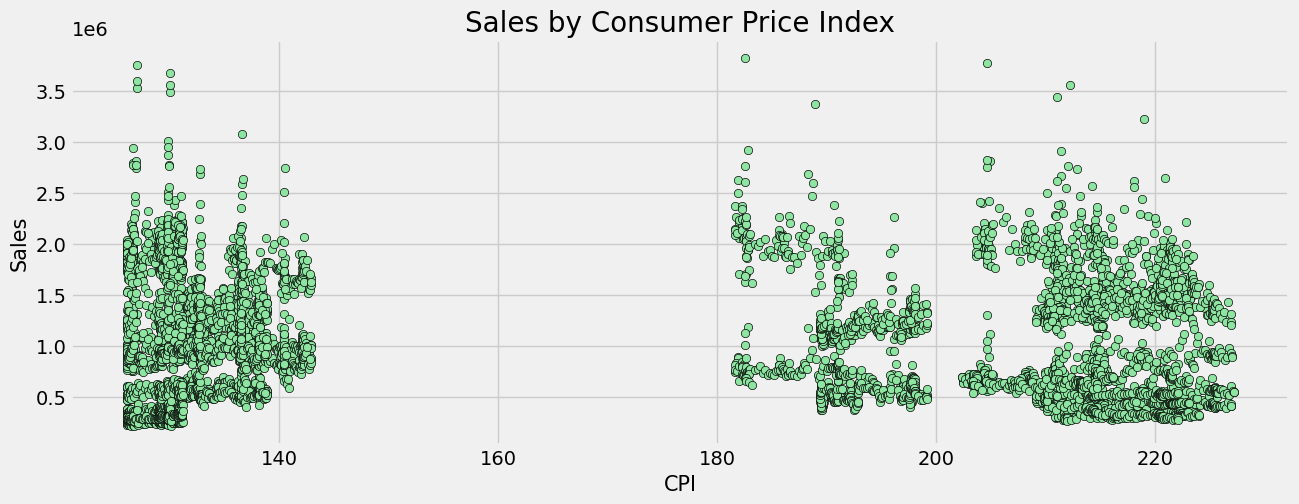

In [37]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'cpi',
                y = 'weekly_sales',
                color = '#8de5a1',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Consumer Price Index', size = 20)
plt.xlabel('CPI', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

 # Consumer Price Index (CPI) does not affect sales. And based on the distribution of average consumer prices in the above figure, customers can be divided into two categories:
    # customers who pay from 120 to 150 (Middle-class customers).
    # customers who pay from 180 to 230 (High-class customers).

In [ ]:
# 6. weekly_sales & unemployment

In [ ]:
# Q7: What happens to sales based on the unemployment rate?

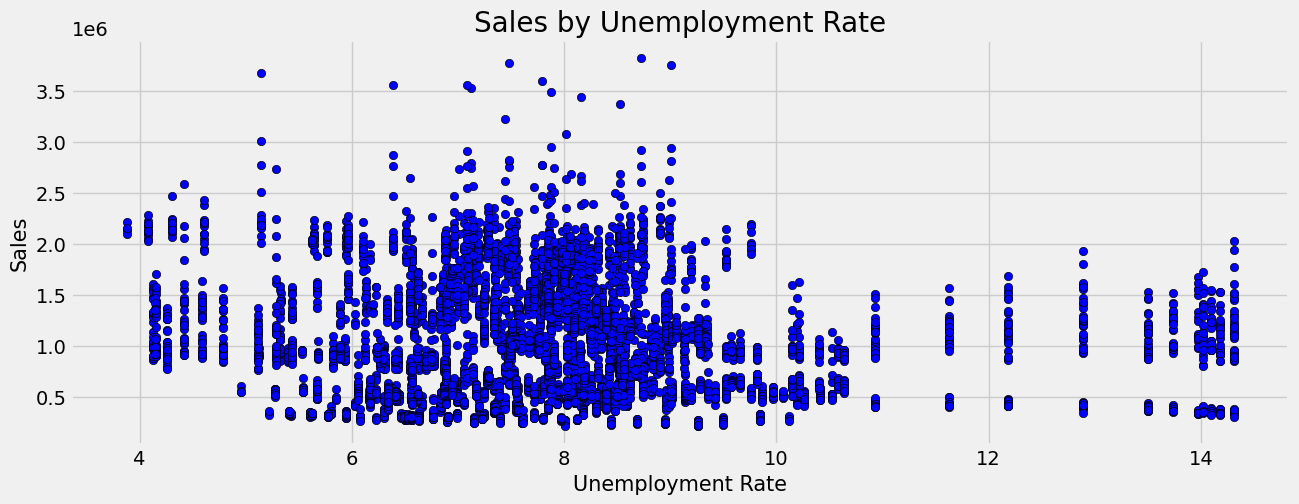

In [38]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'unemployment',
                y = 'weekly_sales',
                color = 'blue',
                edgecolor = 'black')

# Add labels and title
plt.title('Sales by Unemployment Rate', size = 20)
plt.xlabel('Unemployment Rate', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

  #Sales are affected by the unemployment rate, so the higher the unemployment rate, the lower the sales.

In [ ]:
......................................

In [ ]:
# Time Series Analysis

In [ ]:
# Q8: What are the total sales in each year?

In [39]:
data.groupby('year')['weekly_sales'].sum().sort_values(ascending = False)


year
2011    2.448200e+09
2010    2.288886e+09
2012    2.000133e+09
Name: weekly_sales, dtype: float64

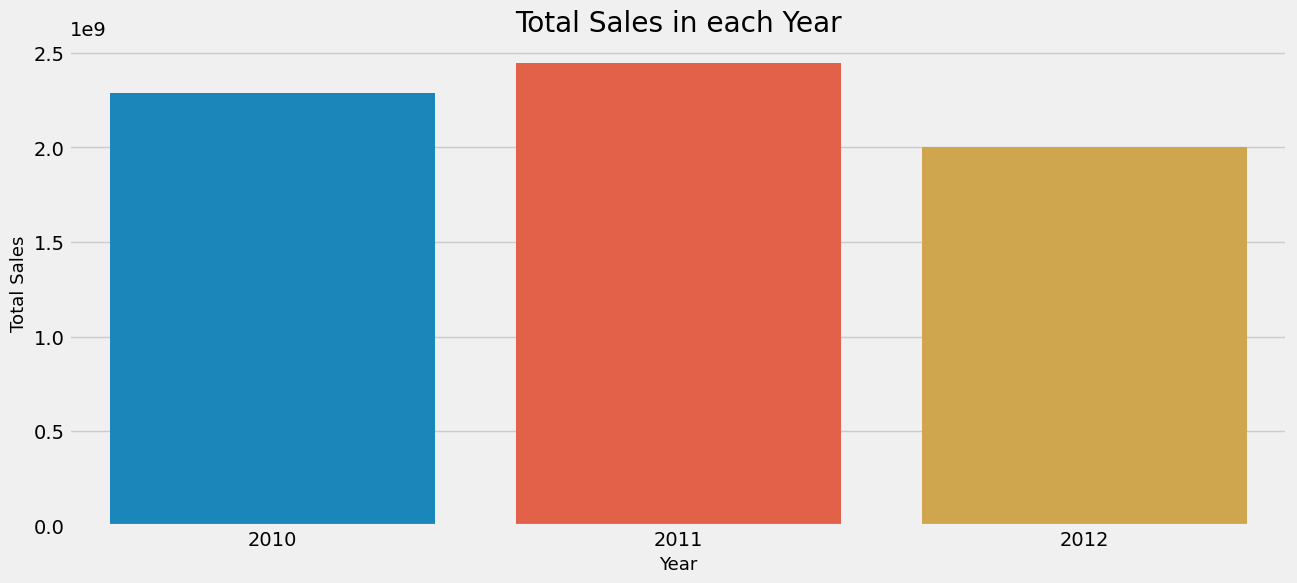

In [40]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Year')
plt.xlabel('Year', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [ ]:
# Conclusion:

 # Total sales in 2011 were the highest, with 2,448,200,007$

In [ ]:
# Q9: What are the total sales in each season?

In [41]:
data.groupby('season')['weekly_sales'].sum().sort_values(ascending = False)

season
Summer    1.841852e+09
Spring    1.826615e+09
Autumn    1.574639e+09
Winter    1.494112e+09
Name: weekly_sales, dtype: float64

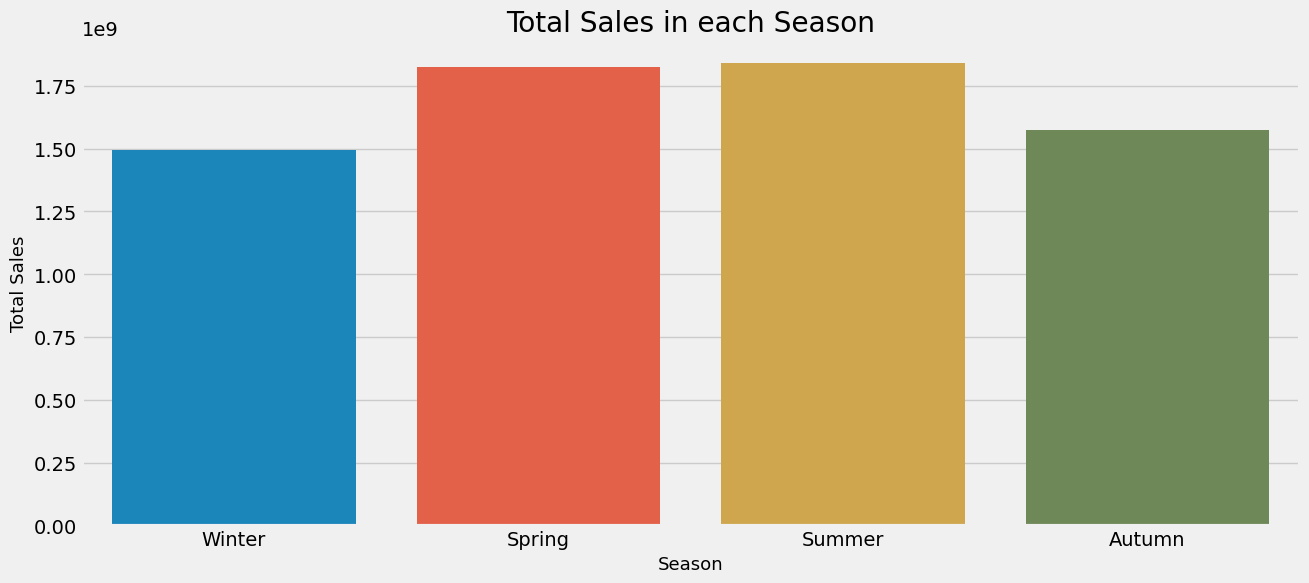

In [42]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'season',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Season')
plt.xlabel('Season', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [ ]:
# Conclusion:

  # Total sales for all years in Summer are the highest from all seasons, with 1,1,841,852,365$.

In [ ]:
# Q10: What are the total sales in each month?

In [43]:
data.groupby('month_name')['weekly_sales'].sum().sort_values(ascending = False)

month_name
July         6.500010e+08
April        6.468598e+08
June         6.226299e+08
August       6.130902e+08
March        5.927859e+08
October      5.847848e+08
September    5.787612e+08
December     5.768386e+08
February     5.687279e+08
May          5.571256e+08
November     4.130157e+08
January      3.325984e+08
Name: weekly_sales, dtype: float64

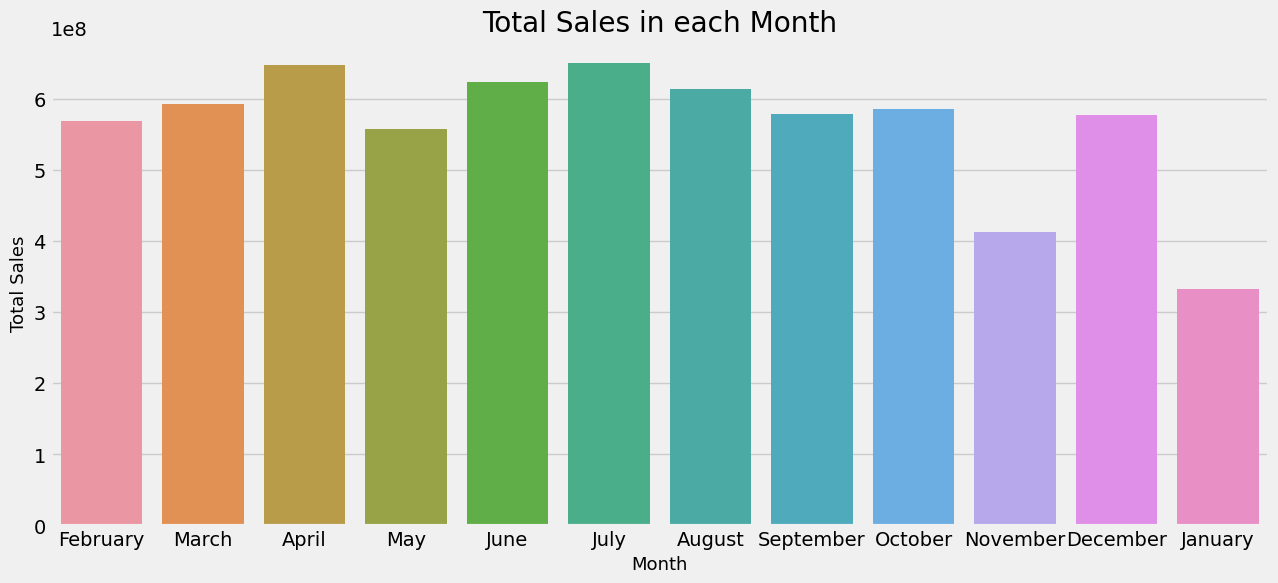

In [44]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'month_name',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Month')
plt.xlabel('Month', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

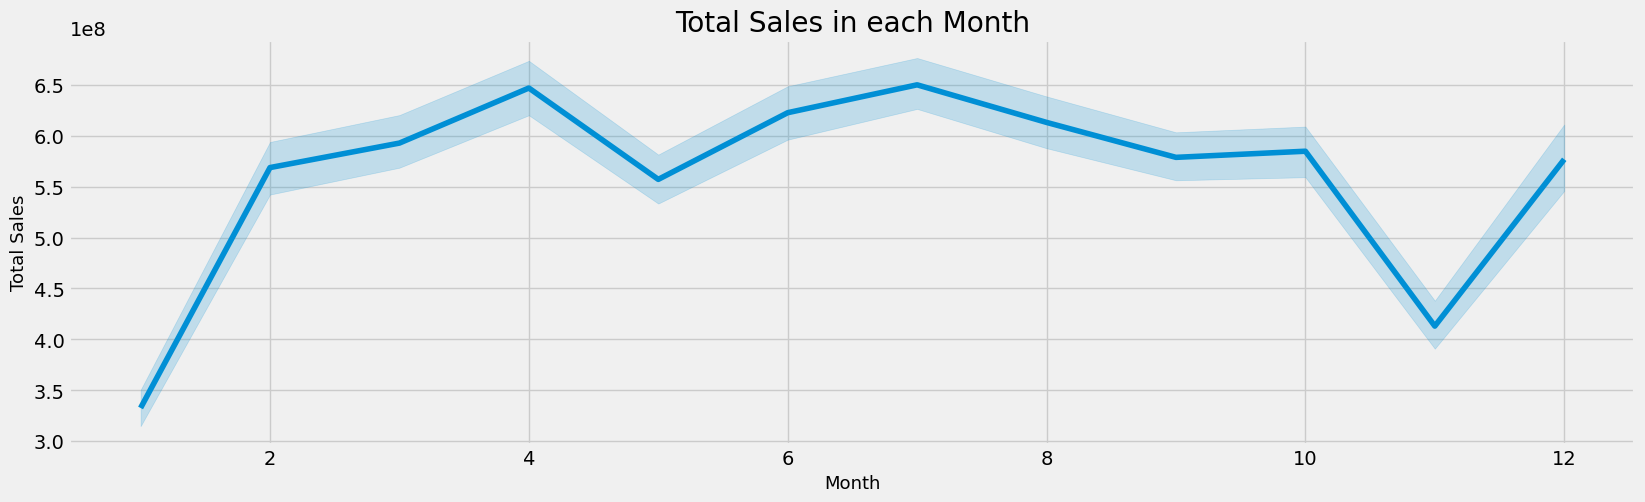

In [45]:
plt.figure(figsize = (18, 5))
sns.lineplot(data = data,
            x = 'month',
            y = 'weekly_sales',
            estimator = np.sum)

# Add labels and title
plt.title('Total Sales in each Month')
plt.xlabel('Month', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [ ]:
# Conclusion:

  # Total sales for all years in July are the highest from any month, with 650,000,977$

In [ ]:
# Q11: What are the total sales in each week?

In [46]:
gp_week = data.groupby('week')['weekly_sales'].sum().sort_values(ascending = False)
gp_week

week
51    1.579297e+08
22    1.472422e+08
7     1.471902e+08
27    1.470118e+08
14    1.467551e+08
6     1.456823e+08
23    1.451475e+08
31    1.437064e+08
24    1.434817e+08
26    1.430931e+08
18    1.424894e+08
5     1.419895e+08
33    1.413328e+08
21    1.409434e+08
34    1.407740e+08
36    1.407277e+08
9     1.407131e+08
25    1.401614e+08
32    1.401174e+08
40    1.398813e+08
35    1.397305e+08
13    1.391557e+08
16    1.384837e+08
10    1.380332e+08
28    1.378596e+08
19    1.377021e+08
15    1.367863e+08
11    1.367628e+08
29    1.362228e+08
20    1.359906e+08
43    1.350028e+08
42    1.340080e+08
8     1.338659e+08
41    1.336528e+08
47    1.324146e+08
30    1.324108e+08
12    1.320040e+08
37    1.311007e+08
17    1.309520e+08
38    1.284312e+08
39    1.281706e+08
50    1.219065e+08
49    1.112279e+08
48    9.929958e+07
45    9.459903e+07
44    9.443753e+07
46    9.156456e+07
1     8.773121e+07
52    8.647498e+07
3     8.273564e+07
2     8.269676e+07
4     7.943483e+07
Name: w

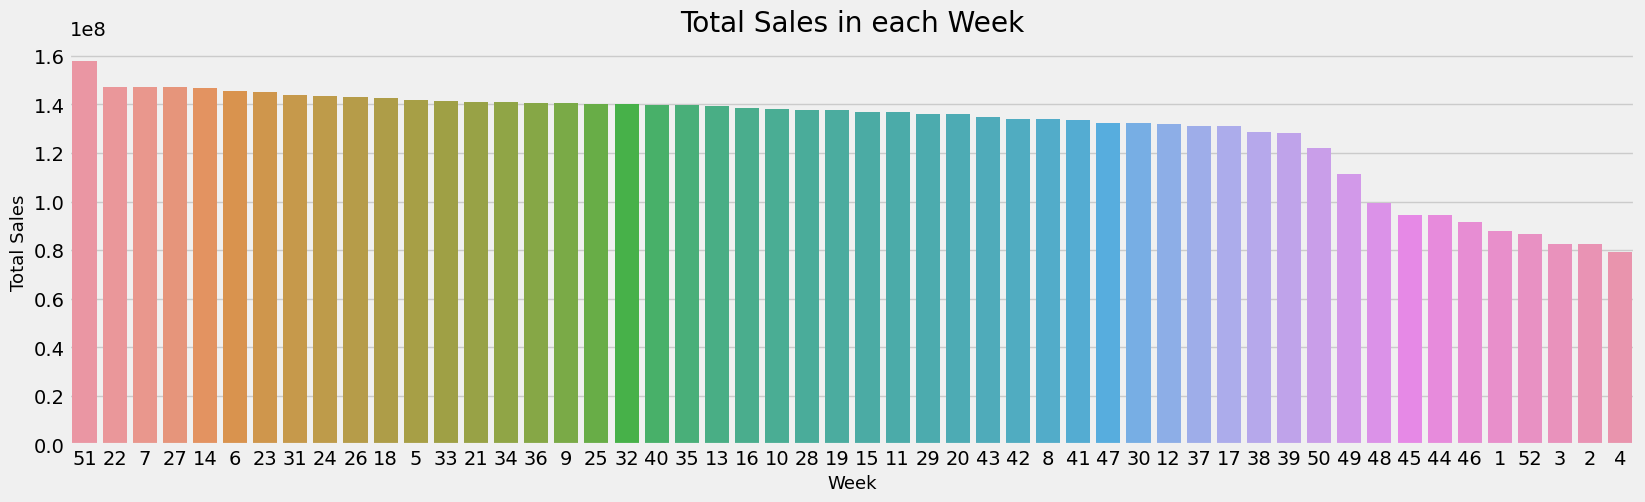

In [47]:
plt.figure(figsize = (18, 5))
sns.barplot(data = data,
            x = 'week',
            y = 'weekly_sales',
            estimator = np.sum,
            order = gp_week.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Week')
plt.xlabel('Week', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

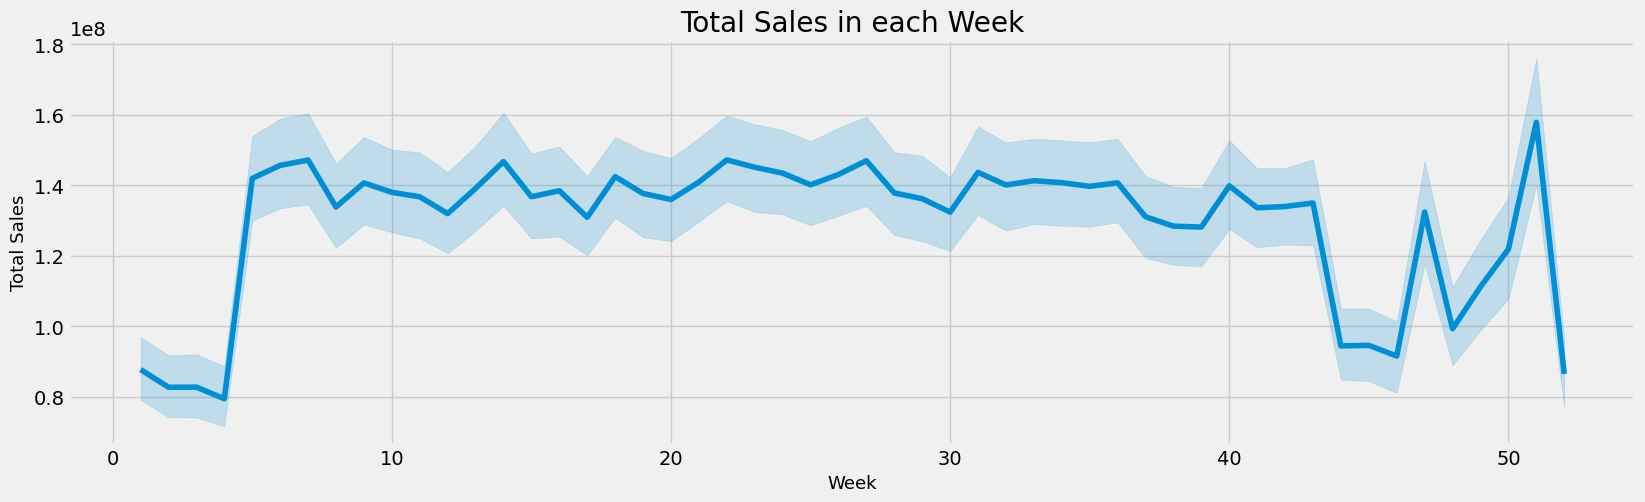

In [62]:
plt.figure(figsize = (18, 5))
sns.lineplot(data = data,
            x = 'week',
            y = 'weekly_sales',
            estimator = np.sum)

# Add labels and title
plt.title('Total Sales in each Week')
plt.xlabel('Week', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [ ]:
# Conclusion:

  # Total sales for all years in week 51 are the highest from any week, with 157,929,657$.

In [ ]:
# Q12: What are the total sales in each year regarding the month?

In [48]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'month_name',
               values = 'weekly_sales',
               aggfunc = 'sum')

month_name         April        August      December      February  \
year                                                                 
2010        2.314124e+08  1.876401e+08  2.887605e+08  1.903330e+08   
2011        2.265265e+08  1.885993e+08  2.880781e+08  1.863313e+08   
2012        1.889209e+08  2.368508e+08           NaN  1.920636e+08   

month_name       January          July          June         March  \
year                                                                 
2010                 NaN  2.325801e+08  1.922462e+08  1.819198e+08   
2011        1.637040e+08  2.299114e+08  1.897734e+08  1.793564e+08   
2012        1.688945e+08  1.875095e+08  2.406103e+08  2.315097e+08   

month_name           May      November       October     September  
year                                                                
2010        1.867109e+08  2.028534e+08  2.171618e+08  1.772679e+08  
2011        1.816482e+08  2.101624e+08  1.832613e+08  2.208477e+08  
2012        1.887665e+08           NaN  1.843617e+08  1.806455e+08

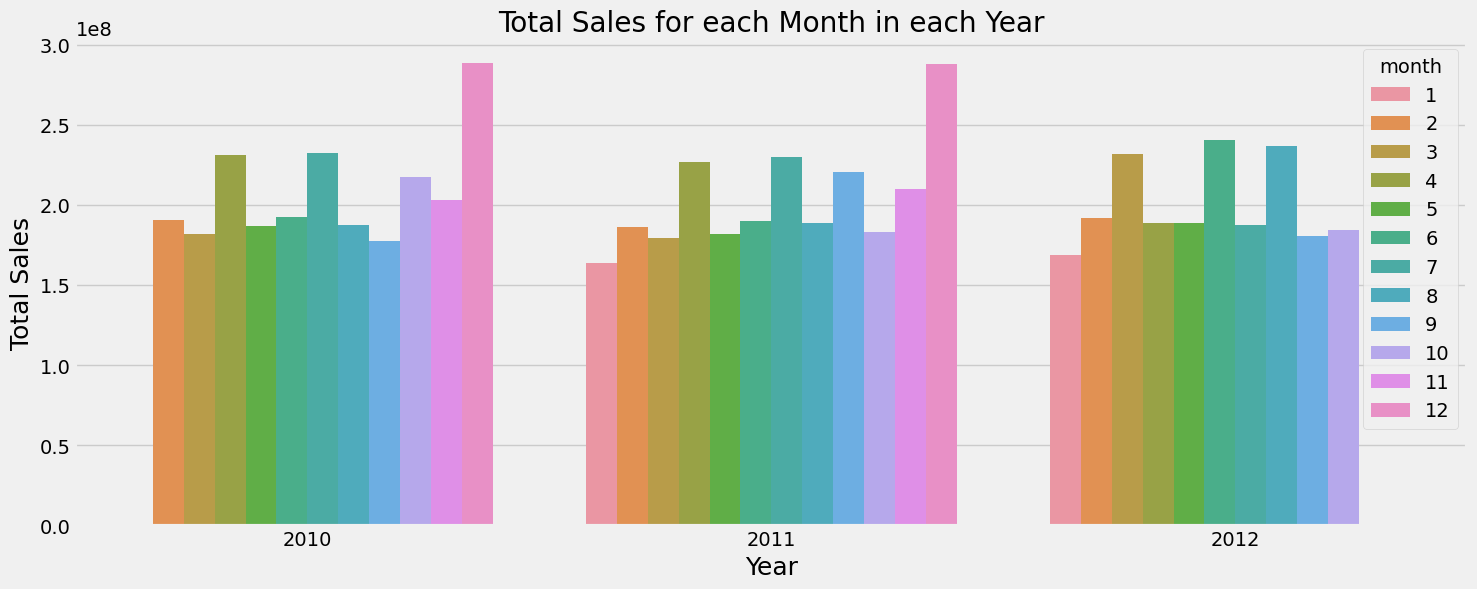

In [49]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'month',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales for each Month in each Year')
plt.xlabel('Year', size = 18)
plt.ylabel('Total Sales', size = 18)

plt.show()

In [ ]:
# Conclusion:

  # Total sales in December 2010, 2011 are the highest in the three years, where:

      # 1. In 2010, total sales in December were the highest with 288,760,533.
      # 2. In 2011, total sales in December were the highest with 288,760,533.
      # 3. In 2012, total sales in June were the highest with 240,610,329$.

In [ ]:
# Q13: What are the total sales in each year regarding the season?

In [50]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'season',
               values = 'weekly_sales',
               aggfunc = 'sum')

season        Autumn        Spring        Summer        Winter
year                                                          
2010    7.087757e+08  6.103695e+08  5.974881e+08  3.722528e+08
2011    6.815017e+08  5.979481e+08  6.393585e+08  5.293917e+08
2012    1.843617e+08  6.182977e+08  6.050058e+08  5.924677e+08

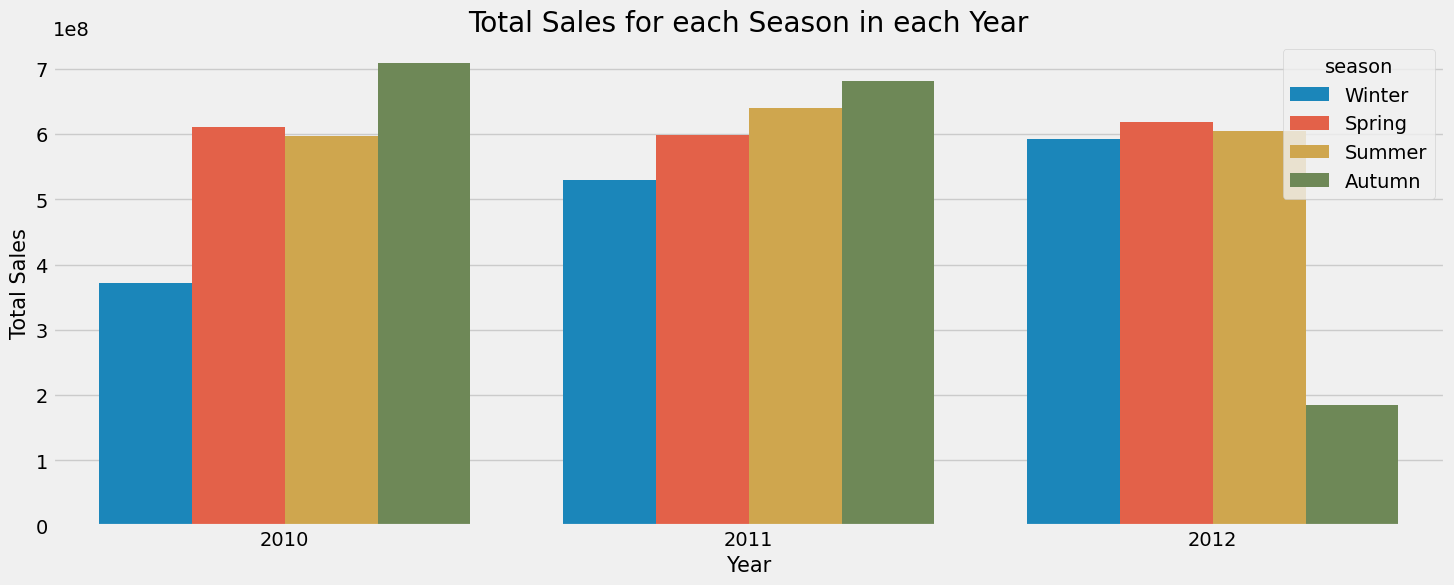

In [51]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'season',
            estimator = np.sum,
           ci = False)

# Add labels and title
plt.title('Total Sales for each Season in each Year')
plt.xlabel('Year', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

  # Total sales in Autumn 2010 were the highest in the three years, where:

     # 1. In 2010, total sales in Autumn were the highest with 708,775,727.
     # 2. In 2011, total sales in Autumn were the highest with 681,501,740.
     # 3. In 2012, total sales in Spring were the highest with 618,297,715$.

In [ ]:
# Q14: What are the total sales in each year regarding the day of the week?

In [52]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'day_of_week',
               values = 'weekly_sales',
               aggfunc = 'sum')

day_of_week        Friday
year                     
2010         2.288886e+09
2011         2.448200e+09
2012         2.000133e+09

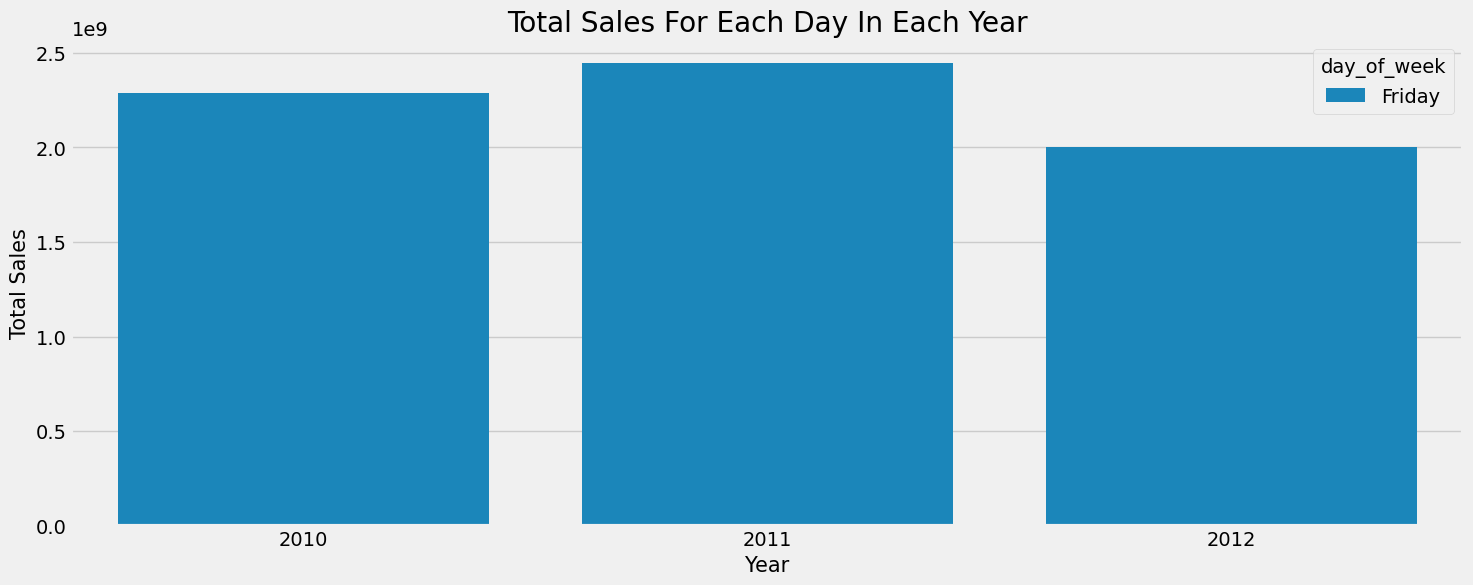

In [53]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'day_of_week',
            estimator = np.sum,
           ci = False)

# Add labels and title
plt.title('Total Sales For Each Day In Each Year')
plt.xlabel('Year', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

In [ ]:
# Conclusion:

   # Total weekly sales in Fridays 2011 were the highest in the three years, where:
     # 1. In 2010, total sales on Fridays were the highest with 2,288,886,120.
     # 2. In 2011, total sales on Fridays were the highest with 2,448,200,007.
     # 3. In 2012, total sales on Fridays were the highest with 2,000,132,859.

In [ ]:
# Q15: What happened to the total sales over time?

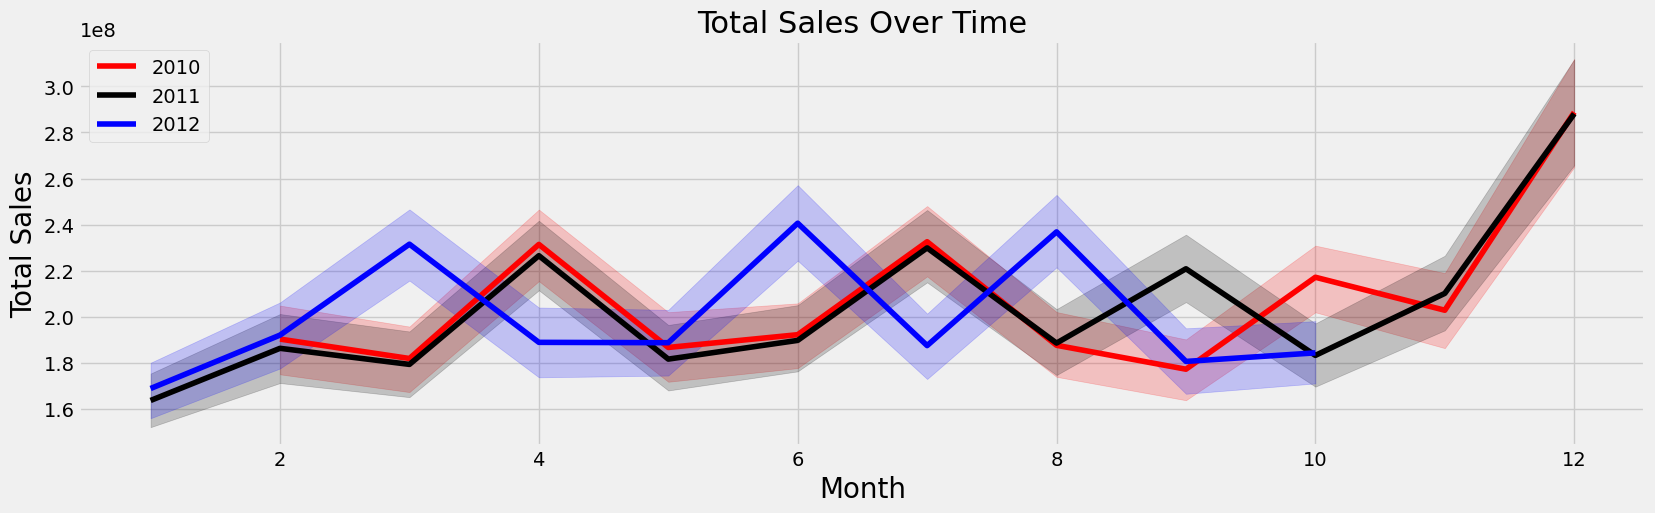

In [55]:
years = ['2010', '2011', '2012']
colors = ['red', 'black', 'blue']

plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'weekly_sales',
                 estimator = np.sum,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Total Sales Over Time', size = 22)
plt.xlabel('Month', size = 20)
plt.ylabel('Total Sales', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Conclusion:

  # Sales are similar in most months, but they increased at the end of 2010 and 2011 and decreased at the end of 2012

In [ ]:
# Q17: What happened to the average sales over time?

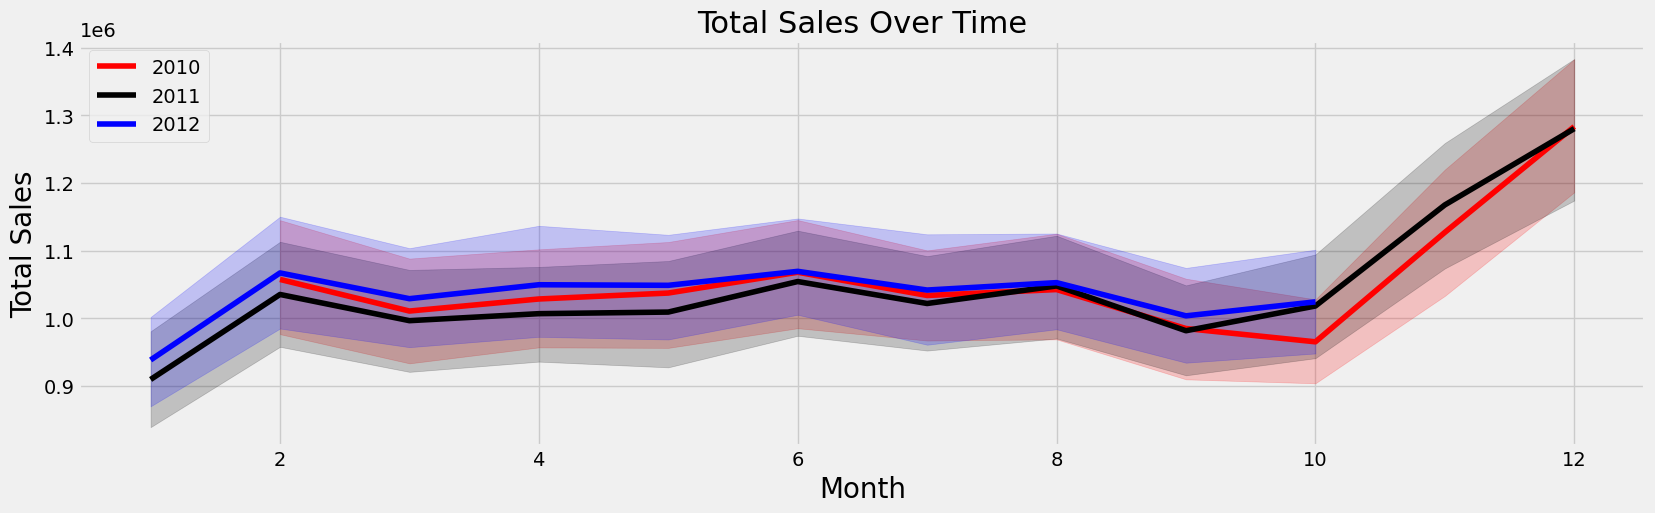

In [56]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'weekly_sales',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Total Sales Over Time', size = 22)
plt.xlabel('Month', size = 20)
plt.ylabel('Total Sales', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Conclusion:

  # Sales rates are similar in most months, but they increased at the end of 2010 and 2011 and decreased at the end of 2012.

In [ ]:
# Q18: What happens to the unemployment rate over time?

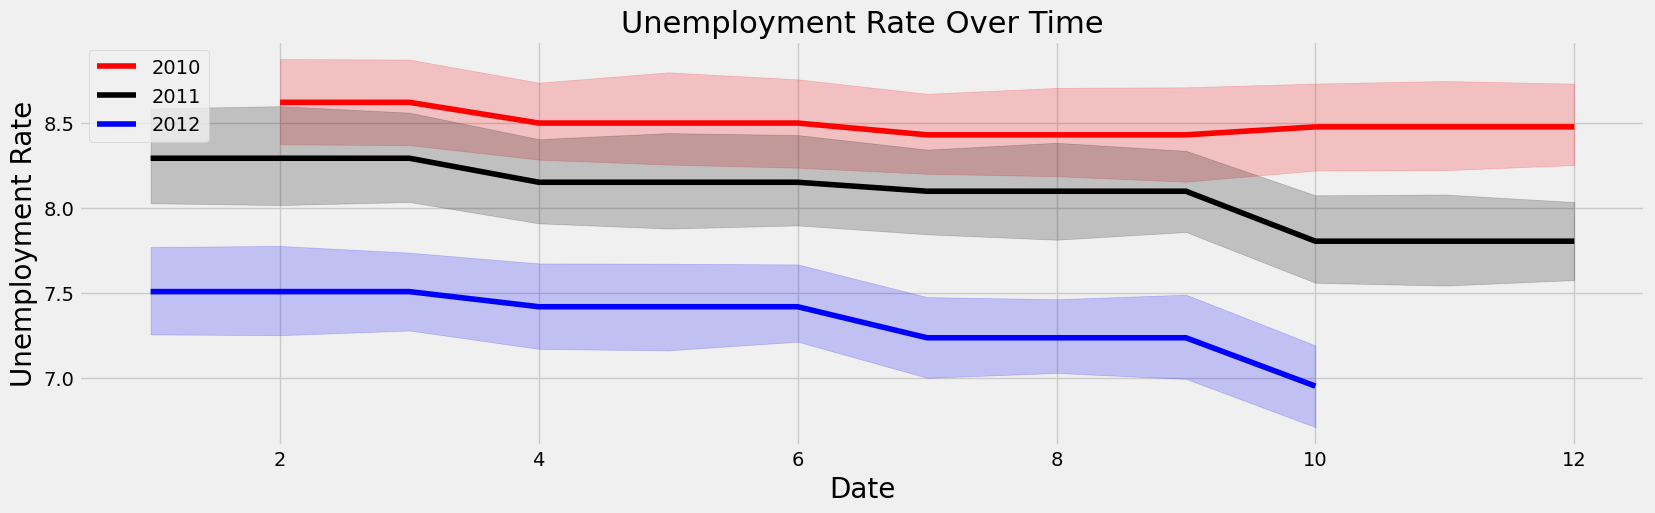

In [57]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'unemployment',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Unemployment Rate Over Time', size = 22)
plt.xlabel('Date', size = 20)
plt.ylabel('Unemployment Rate', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Conclusion:

 # The unemployment rate decreases over time.

In [ ]:
# Q19: What happens to the fuel price rate over time?

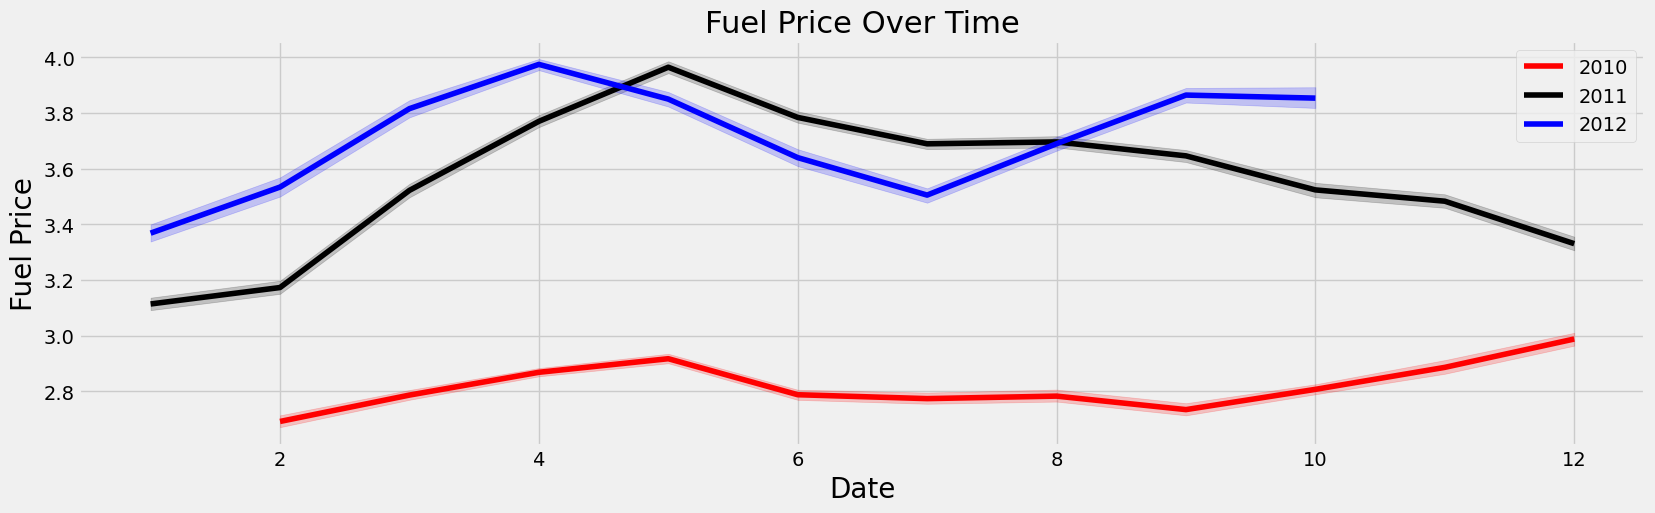

In [58]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'fuel_price',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Fuel Price Over Time', size = 22)
plt.xlabel('Date', size = 20)
plt.ylabel('Fuel Price', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Conclusion:

  # The fuel price increases over time.

In [ ]:
# Data Correlation

In [ ]:
#  Correlation : 
   # A measure of the extent of interdependence between variables.

    
# Pearson Correlation: 
  # The Pearson Correlation measures the linear dependence between two variables X and Y.

    
# The resulting coefficient is a value between -1 and 1 inclusive, where:

  #1.   1: Perfect positive linear correlation.
  #2.   0: No linear correlation, the two variables most likely do not affect each other.
  #3.  -1: Perfect negative linear correlation.


In [ ]:
# P-value

# What is this P-value? 
  # The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.

# By convention, when the :

  # p-value is < 0.001: we say there is strong evidence that the correlation is significant.
  # p-value is < 0.05: there is moderate evidence that the correlation is significant.
  # p-value is < 0.1: there is weak evidence that the correlation is significant.
  # p-value is > 0.1: there is no evidence that the correlation is significant.

In [ ]:
# Fuel Price vs. Weekly Sales

In [59]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'fuel_price' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['fuel_price'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.009463786314475134  with a P-value of P = 0.44782874894858093


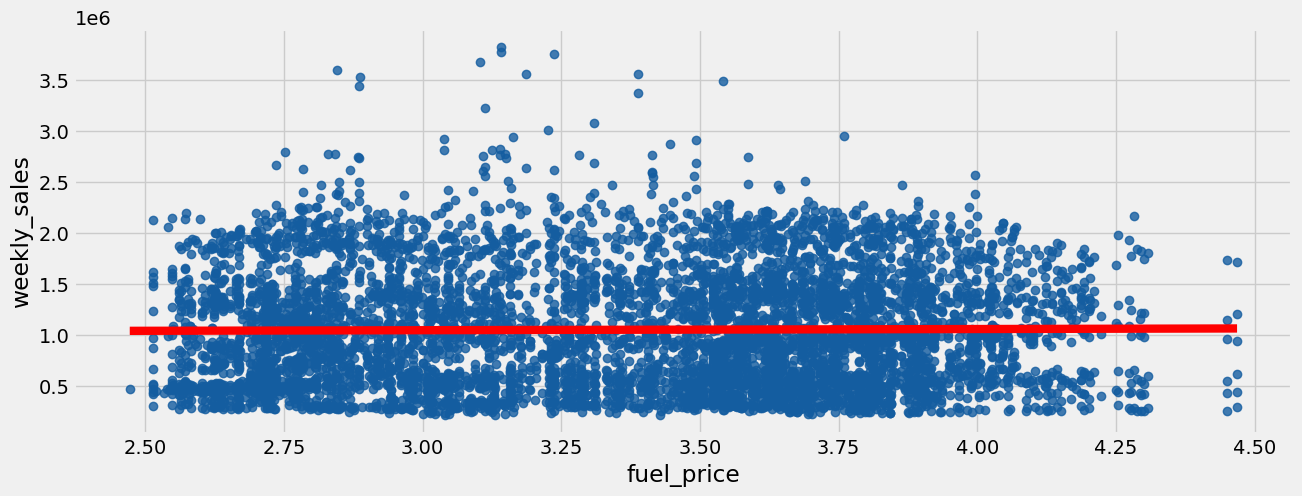

In [60]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'fuel_price', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [ ]:
# Conclusion:

  # 1. Since the p-value is > 0.1, the correlation between fuel price and weekly sales is not statistically significant.
  # 2.  Fuel price does not seem like a good predictor of the weekly sales at all since the regression line is close to horizontal. Therefore, it's not a reliable variable

In [ ]:
# Unemployment vs. Weekly Sales

In [61]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'unemployment' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['unemployment'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.10617608965795422  with a P-value of P = 1.3448365210234661e-17


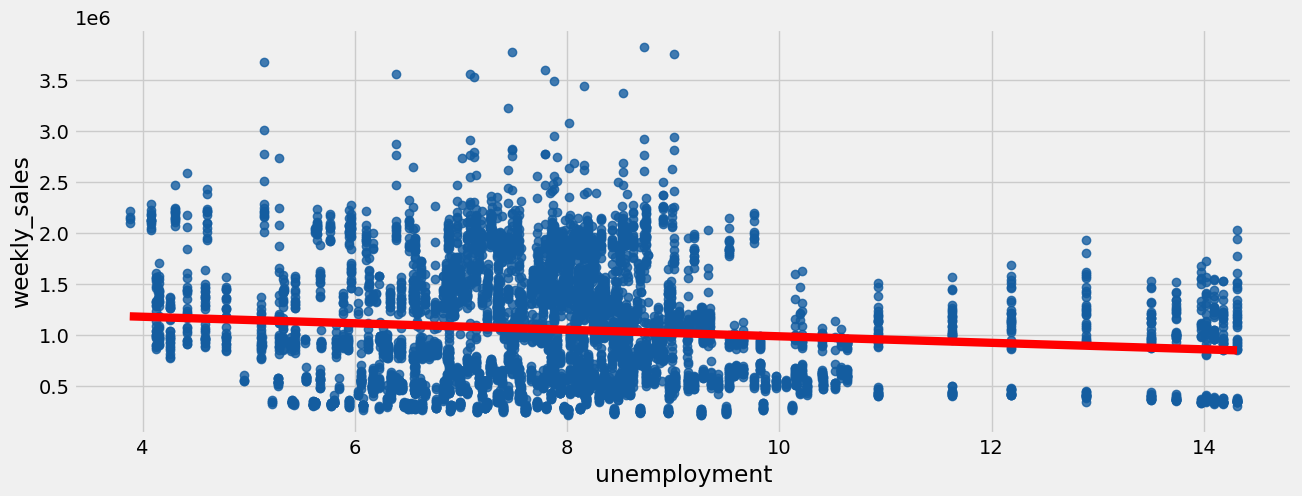

In [62]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'unemployment', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [ ]:
# Conclusion:-

  # 1. Since the p-value is < 0.001, the correlation between unemployment and weekly sales is strong evidence that the correlation is significant.
  # 2. Unemployment seems like a good predictor of the weekly sales, The higher the unemployment rate, the lower the weekly sales.

In [ ]:
# CPI vs. Weekly Sales

In [63]:
# Let's calculate the Pearson Correlation Coefficient and P-value of cpi' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['cpi'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.0726341620401763  with a P-value of P = 5.438292612176735e-09


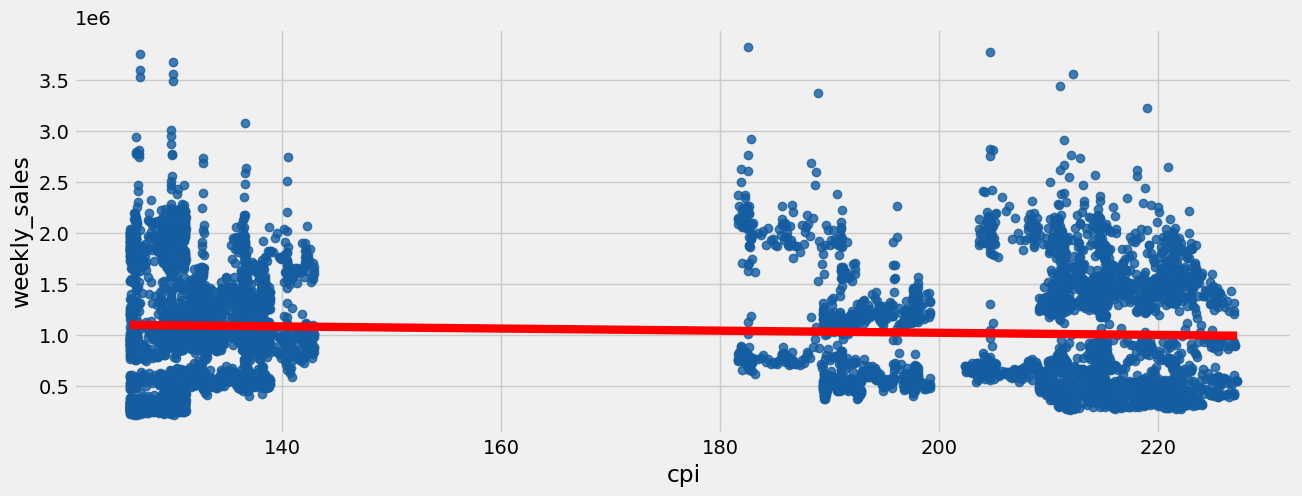

In [64]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'cpi', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [ ]:
# Conclusion:

  # Since the p-value is < 0.001, the correlation between CPI and weekly sales is strong evidence that the correlation is significant.

In [ ]:
# Temperature vs. Weekly Sales

In [65]:
# Let's calculate the Pearson Correlation Coefficient and P-value of temperature' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['temperature'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.06381001317946956  with a P-value of P = 3.007647625833226e-07


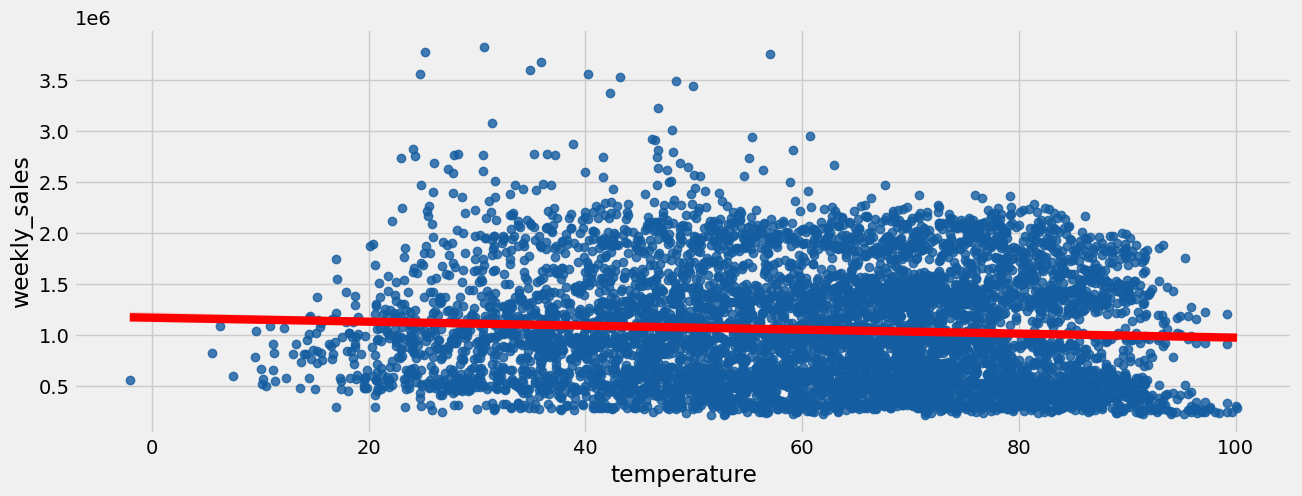

In [66]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'temperature', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [ ]:
# Conclusion:

  # 1. Since the p-value is < 0.05, the correlation between temperature and weekly sales is moderate evidence that the correlation is significant.
  # 2. Temperature seems like a good predictor of the weekly sales, The higher the Temperature rate, the lower the weekly sales.

In [76]:
# Correlations with weekly sales
corr = data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr()['weekly_sales'].sort_values(ascending = False)
corr = corr.to_frame()

corr.style.background_gradient(cmap="RdYlBu")

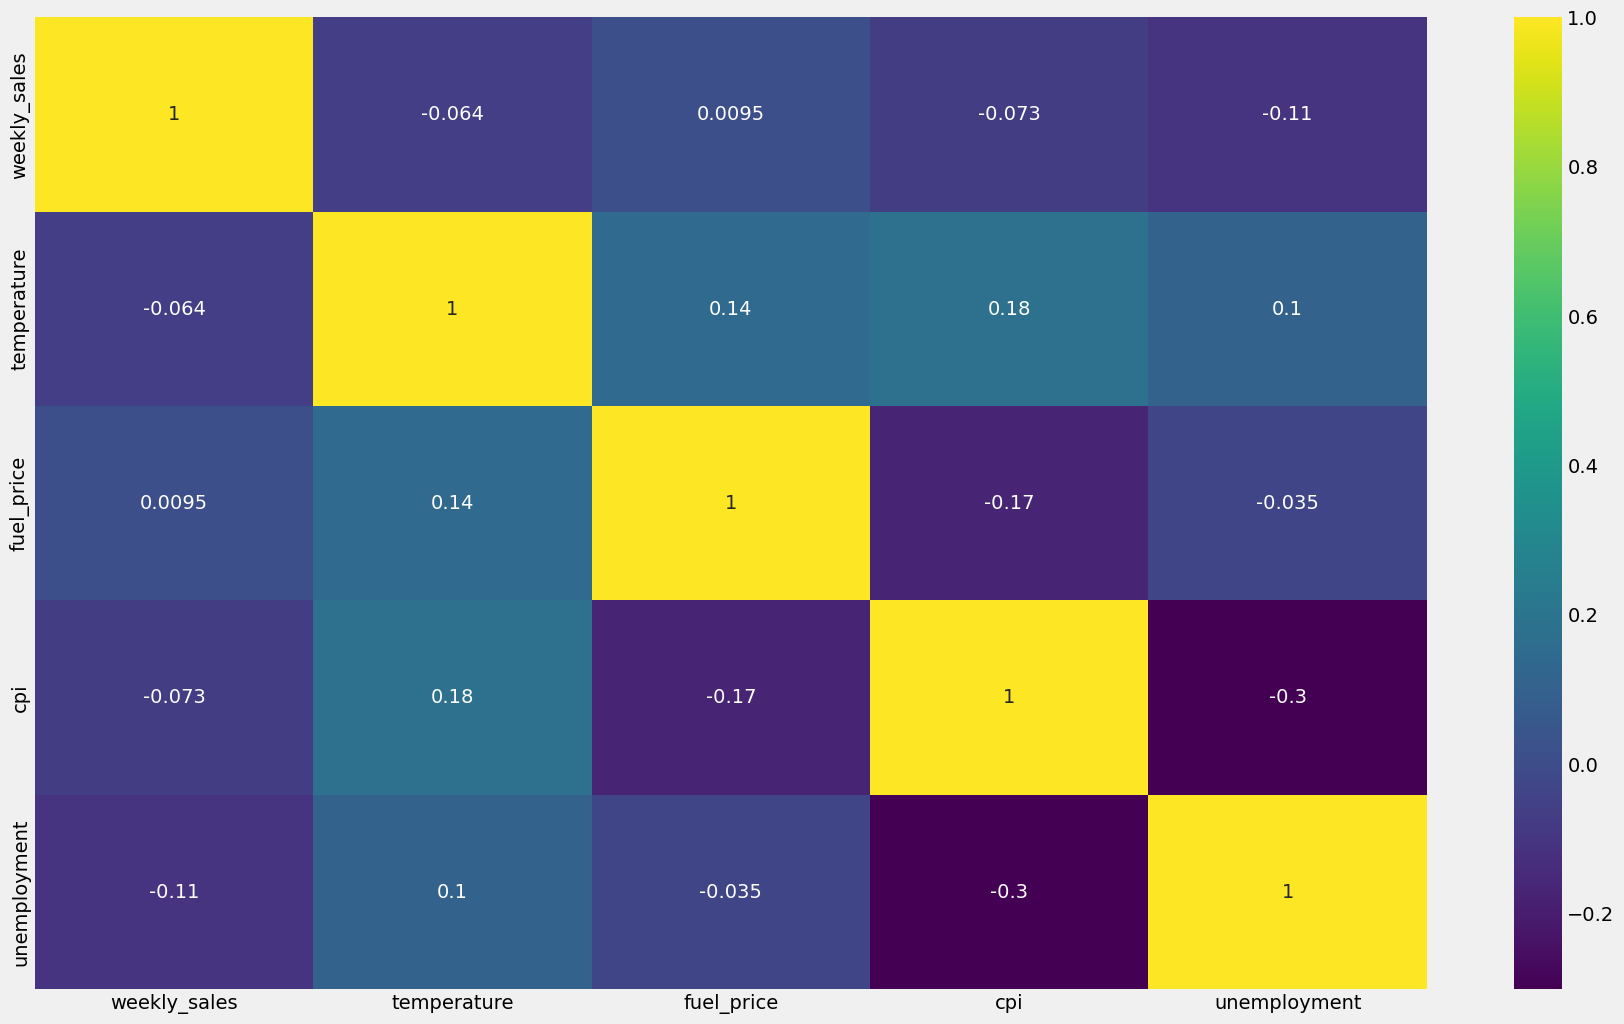

In [68]:
# Heatmap to explain the correlation between the features
plt.figure(figsize = (20, 12))
sns.heatmap(data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr(), annot = True, cmap='viridis')
plt.show()

In [ ]:
# Data Pre-processing

In [ ]:
# 1. Taking A Copy Of The Data

In [69]:
data_copy = data.copy()

In [ ]:
# 2. Dropping Unnecessary Columns

In [ ]:
# Let's drop columns 'date', 'year' and drop columns 'quarter' and 'month'since there are the same columns as 'season' and 'month_name'.

# In the "day_of_week" column, Friday is the most frequent with 67.1% compared to other days, so the model will be biased to the class of Friday, so it prefers to drop this column to avoid underfitting.

In [70]:
data_copy.drop(['date', 'year', 'quarter', 'month', 'day_of_week'], axis = 1, inplace = True)

In [ ]:
# 3. Data Type

In [71]:
# Check the data types
data_copy.dtypes

store             int64
weekly_sales    float64
is_holiday        int64
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week              int32
dtype: object

In [77]:
# let's handle store and holiday columns as categorical features, so we should convert them into categories (objects).bb
data_copy['store'] = data_copy['store'].astype('object')
data_copy['is_holiday'] = data_copy['is_holiday'].astype('object')
data_copy['week'] = data_copy['week'].astype('object')

In [78]:
# Check the data types after convert
data_copy.dtypes

store            object
weekly_sales    float64
is_holiday       object
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week             object
dtype: object

In [ ]:
# 4. Detecting And Removing The Outliers

0 fuel_price
1 temperature
2 cpi
3 unemployment


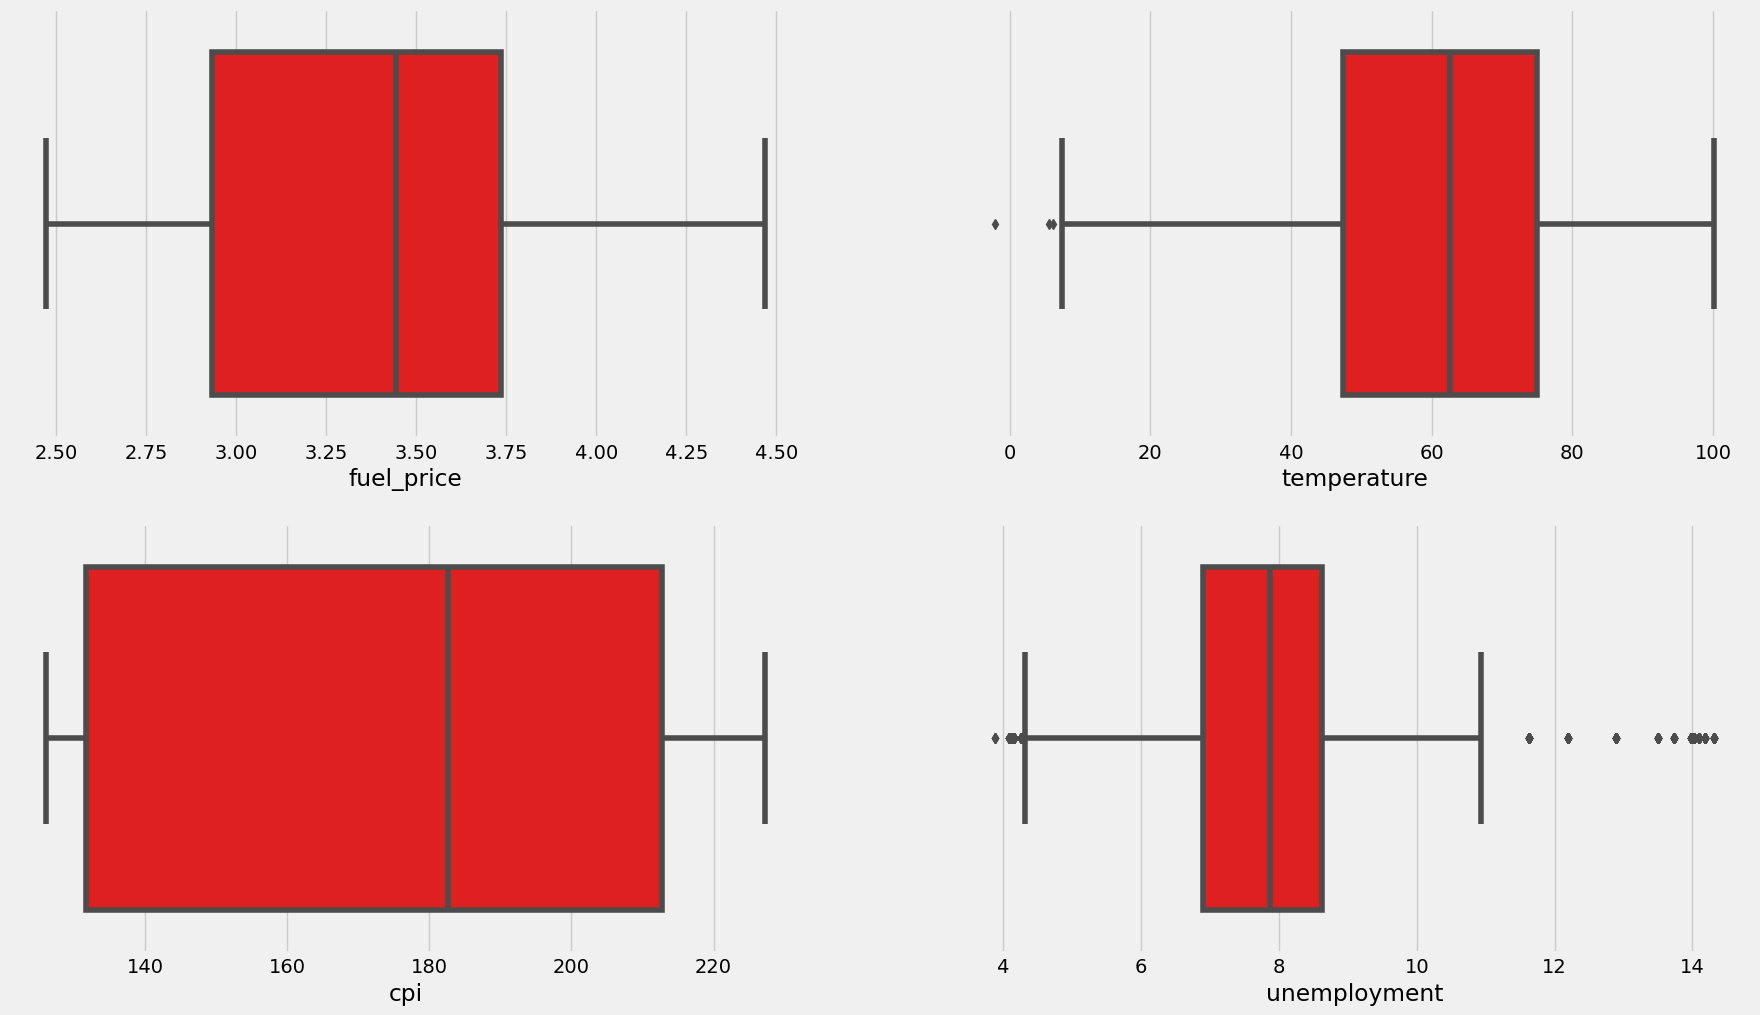

Number of data rows:  6435


In [79]:
cols = ['fuel_price', 'temperature', 'cpi', 'unemployment']
plt.figure(figsize=(20,18))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'red')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [80]:
# Remove outliers from the temperature column
data_copy.drop(data_copy[data_copy['temperature'] < 7].index, axis = 0, inplace = True)

In [81]:
# Remove outliers from the unemployment column
data_copy.drop(data_copy[data_copy['unemployment'] < 4.4].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['unemployment'] > 11].index, axis = 0, inplace = True)

0 temperature
1 fuel_price
2 cpi
3 unemployment


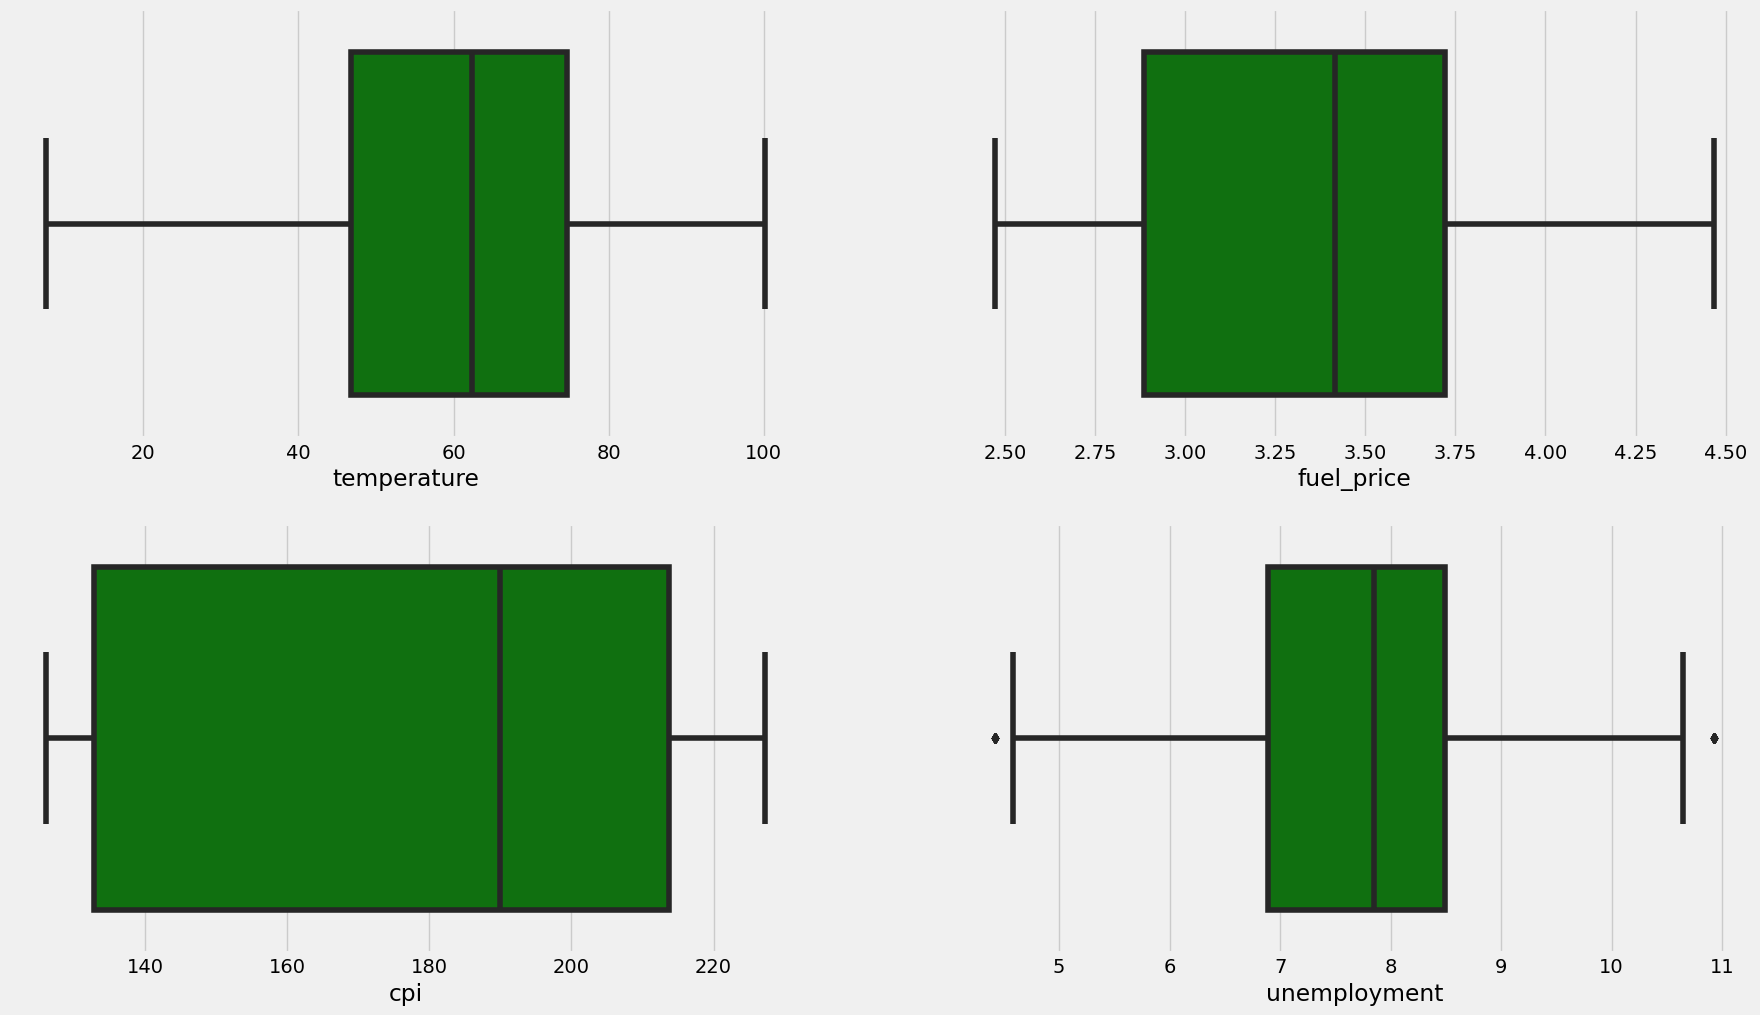

Number of data rows:  5938


In [82]:
cols = ['temperature', 'fuel_price', 'cpi', 'unemployment']
plt.figure(figsize=(20,18))
for i, col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'g')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [ ]:
# 5. Splitting The Data To Training And Testing Data

In [83]:
X = data_copy.drop('weekly_sales', axis = 1)
y = data_copy['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [84]:
print('Shape of data      : ', X.shape)
print('Shape of train data: ', X_train.shape)
print('Shape of test data : ', X_test.shape)

Shape of data      :  (5938, 9)
Shape of train data:  (4750, 9)
Shape of test data :  (1188, 9)


In [ ]:
# 6. Data Transformation

In [85]:
# Splitting the data into Numerical Features and Categorical Features
num_features = data_copy.select_dtypes('number').columns.to_list()
num_features.remove('weekly_sales')

cat_features = data_copy.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['temperature', 'fuel_price', 'cpi', 'unemployment']
Categorical Features: ['store', 'is_holiday', 'season', 'month_name', 'week']


In [86]:
# data transformation pipeline
preprocessor = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temperature', 'fuel_price', 'cpi',
                                  'unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['store', 'is_holiday', 'season', 'month_name',
                                  'week'])])

In [137]:
# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Transform the testing data
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Modeling

In [150]:
def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    print(f'{Training_Testing} Accuracy: \n')
    print(f'-> Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    print(f'-> R-Squere score Training: {round(r2_score(y, predict_data) * 100, 2)} % \n')

In [153]:
def Distribution_Plot(estimator, Training_Testing, X, y, Title):

    """This function is used to perform some model evaluation using training and testing data \
    by plotting the distribution of the actual and predicted values of the training or testing data."""

    # Y predict of X train or X test
    yhat = estimator.predict(X)

    plt.figure(figsize=(14, 6))
    ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
    ax2 = sns.distplot(yhat, hist = False, color = "r", label = f'Predicted Values ({Training_Testing})', ax = ax1)
    plt.title(Title, size = 18)
    plt.legend()
    plt.show()

In [154]:
def cross_validation_score(estimator, X_train, y_train, score = 'r2', n = 5):

    '''This function is to validate the model'''


    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)

    print(f'Cross Validation Scores: {validate} \n')
    print(f'Mean of Scores: {round(validate.mean() * 100, 2)} % \n')
    print(f'Standard Deviation of Scores: {validate.std()}')

In [155]:
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''

 
    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator

In [ ]:
# 1. Linear Regression

In [ ]:
  # 1.1. Creating The Model

In [135]:
# Linear Regression Model
LR = LinearRegression()

# Fitting the data
LR.fit(X_train_transformed, y_train)

LinearRegression()

In [ ]:
 # 1.2. Evaluating The Model (Training)

In [142]:
# Training Accuracy
model_evaluation(LR, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 522051.03
-> R-Squere score Training: 16.11 % 



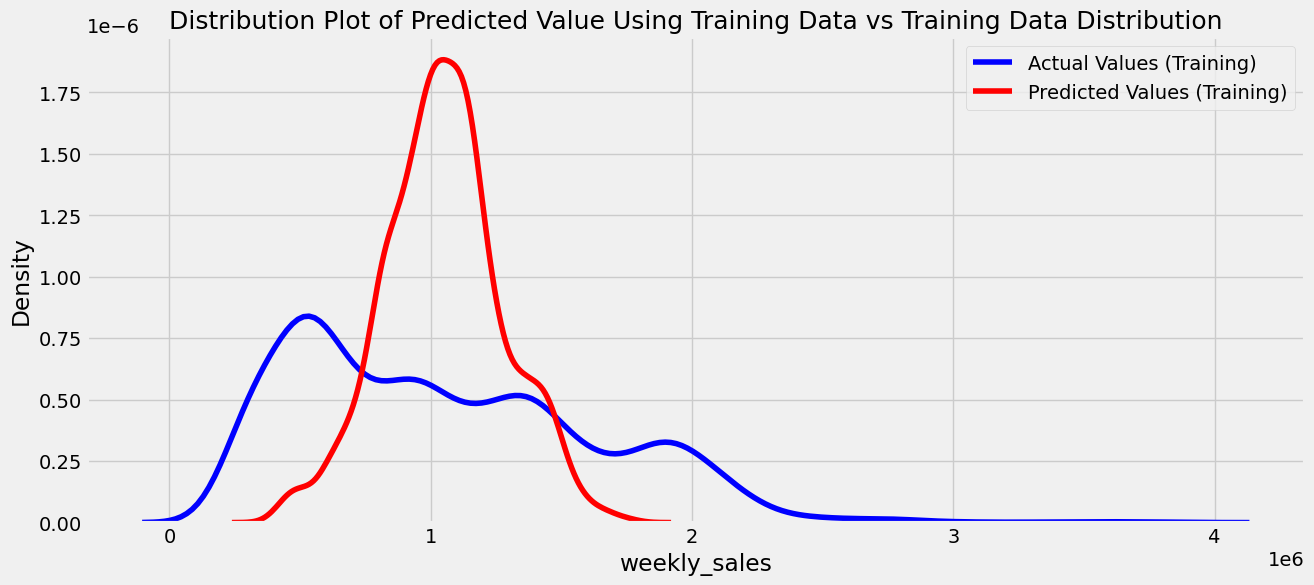

In [95]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(LR, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

  # Since there are no linear correlations between variables and targets, The model seems to be not doing well in learning from the training dataset, so we need to increase the complexity of this model. let's do Polynomial Features for the data before modeling.

In [ ]:
 # 1.3. Tuning The Mode

In [96]:
# Polynomial Regression Model
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

# Define the parameter grid to search
param_grid = {'poly_feat__degree': [2, 3, 4]}

best_estimator = hyperparameter_tunning(LR_pipe, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best parameters: {'poly_feat__degree': 3} 

Best score: 0.9595040606850402


In [97]:
# Linear Regression Model after tuning
poly_reg = best_estimator

In [ ]:
 # 1.4. Evaluating The Model After Tuning

In [98]:
# Training Accuracy Afer tuning
model_evaluation(poly_reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 69404.33
-> R-Squere score Training: 98.52 % 



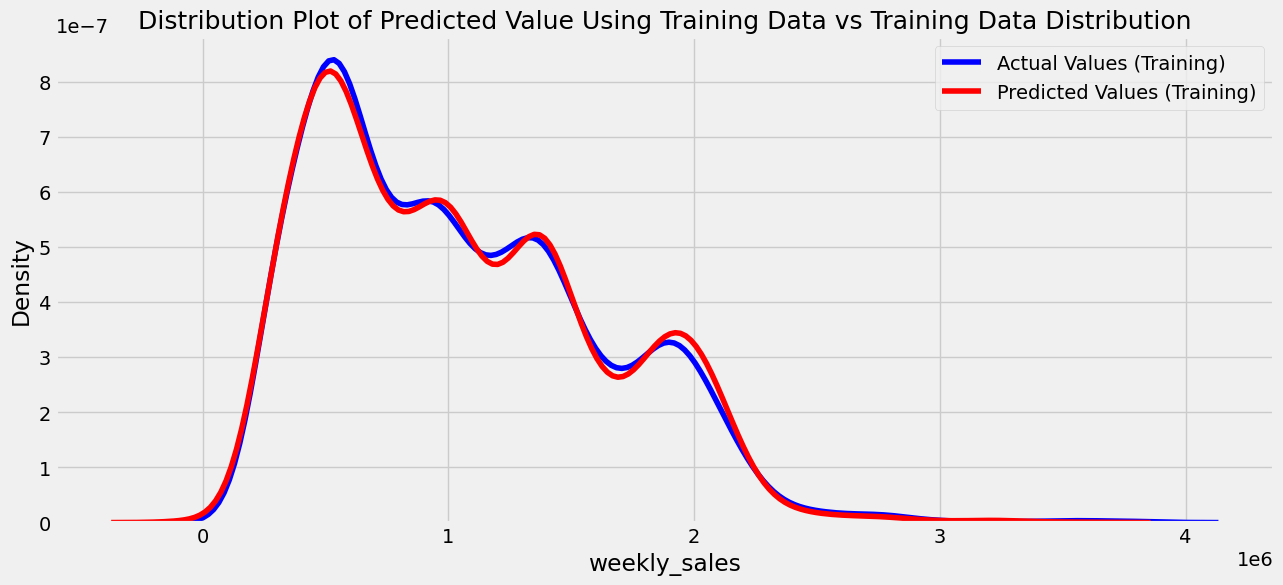

In [99]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(poly_reg, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

  # After applying Polynomial Features to the training data, The model seems to have improved more in learning from the training dataset.

In [ ]:
 # 1.5. Cross Validation Score

In [100]:
cross_validation_score(poly_reg, X_train_transformed, y_train)

Cross Validation Scores: [0.95835446 0.96017332 0.95829588 0.96675781 0.95393884] 

Mean of Scores: 95.95 % 

Standard Deviation of Scores: 0.004166960726542506


In [ ]:
  # 1.6. Testing The Model

In [101]:
# Testing Accuracy
model_evaluation(poly_reg, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 102610.86
-> R-Squere score Training: 96.78 % 



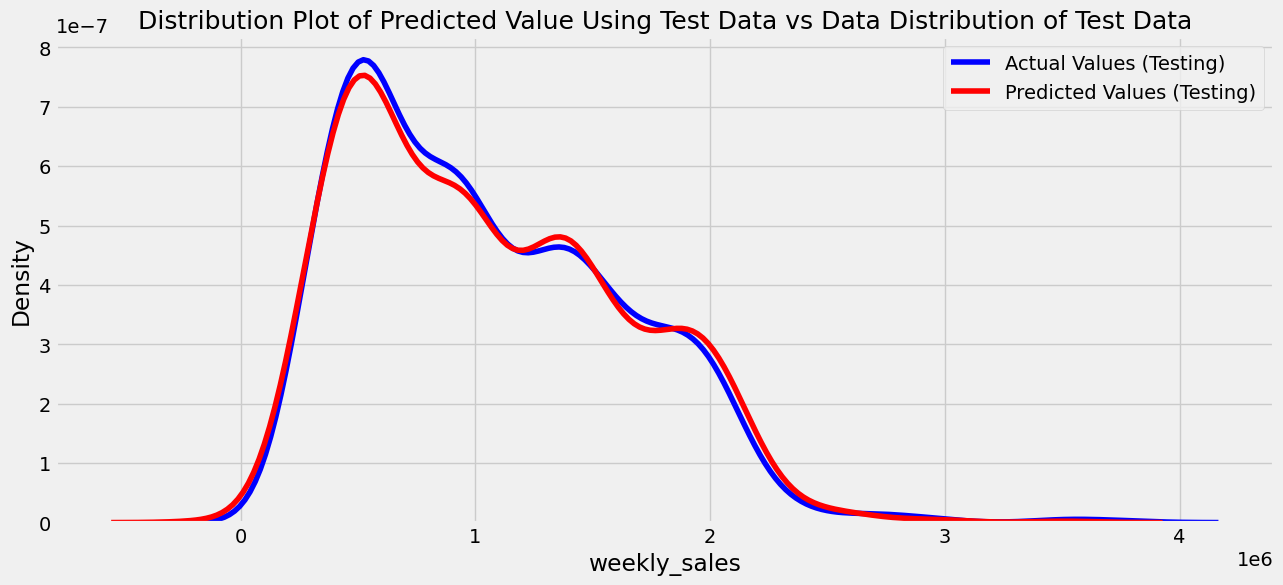

In [102]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(poly_reg, 'Testing', X_test_transformed, y_test, Title)

In [ ]:
# Conclusion:

 # After testing the polynomial regression model, it became clear that the model had learned sufficiently, as its accuracy was 96.84 %.

In [ ]:
# 2. KNN Regressor

In [ ]:
 # 2.1. Creating The Model

In [103]:
# KNN Regression Model
KNN_Reg = KNeighborsRegressor(n_neighbors = 5)

# Fitting the training data
KNN_Reg.fit(X_train_transformed, y_train)

KNeighborsRegressor()

In [ ]:
 # 2.2. Evaluating The Model (Training)

In [104]:
# Training Accuracy
model_evaluation(KNN_Reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 358787.59
-> R-Squere score Training: 60.38 % 



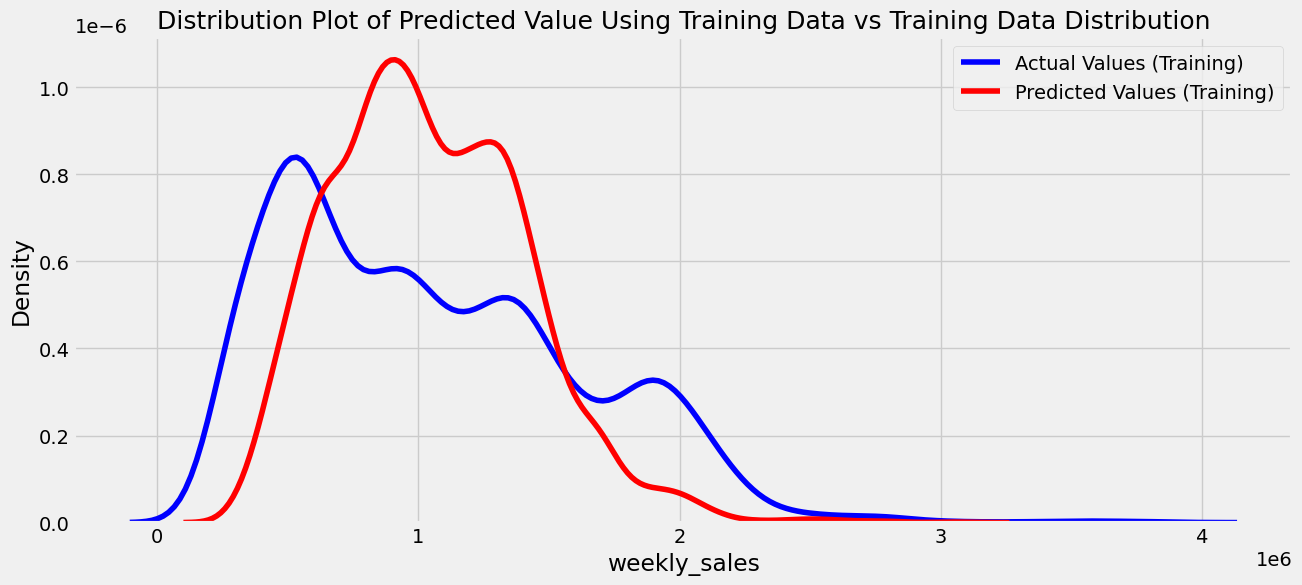

In [105]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(KNN_Reg, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

 # The model seems to be doing not bad in learning from the training dataset.

In [ ]:
 # 2.3. Tuning The Model

In [106]:
# Define the parameter grid to search
param_grid = {'n_neighbors': [1, 3, 5, 7, 8, 9, 11, 13]}

best_estimator = hyperparameter_tunning(KNN_Reg, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_KNN = best_estimator

Best parameters: {'n_neighbors': 13} 

Best score: 0.4231099473150829


In [ ]:
 # 2.4. Evaluating The Model After Tuning

In [107]:
# Training Accuracy Afer tuning
model_evaluation(Best_KNN, 'Training', X_train_transformed, y_train)


Training Accuracy: 

-> Root Mean Squared Error: 395417.64
-> R-Squere score Training: 51.87 % 



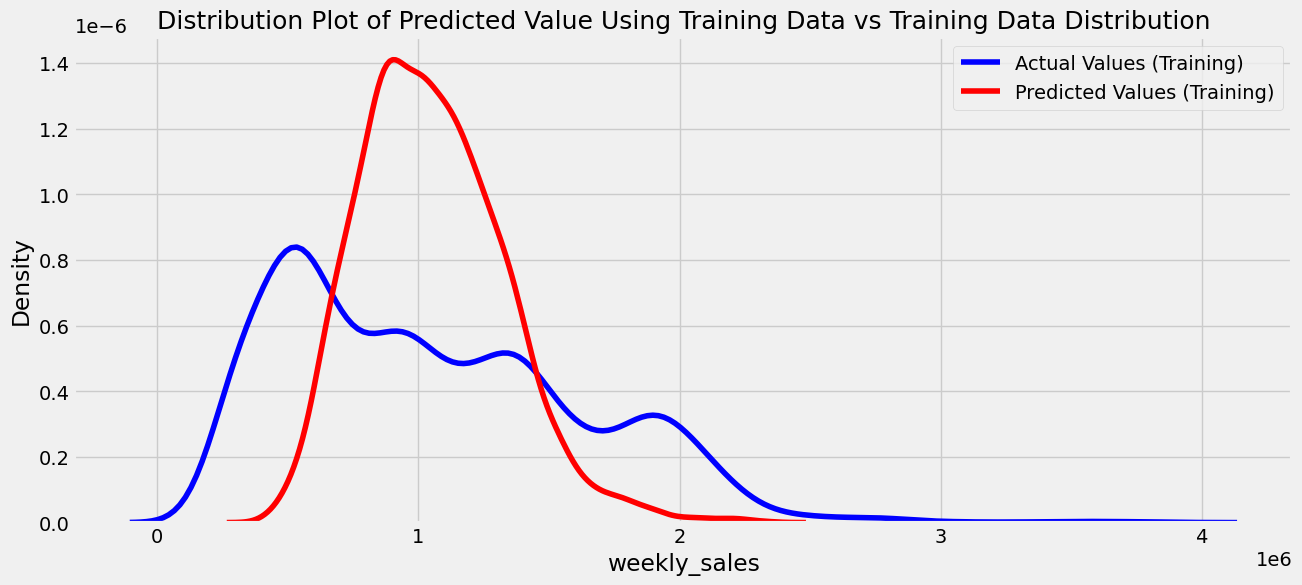

In [108]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_KNN, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

 # After tuning the hyperparameter of n_neighbors, The model seems to have improved a little in learning from the training dataset.

In [ ]:
 # 2.5. Cross Validation Score

In [109]:
cross_validation_score(Best_KNN, X_train_transformed, y_train, n = 10)


Cross Validation Scores: [0.42269564 0.38124587 0.40153214 0.45908764 0.42543618 0.41528988
 0.41172563 0.433573   0.43025631 0.46477738] 

Mean of Scores: 42.46 % 

Standard Deviation of Scores: 0.023631703073025447


In [ ]:
 # 2.6. Testing The Model

In [110]:
# Testing Accuracy
model_evaluation(Best_KNN, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 422609.07
-> R-Squere score Training: 45.39 % 



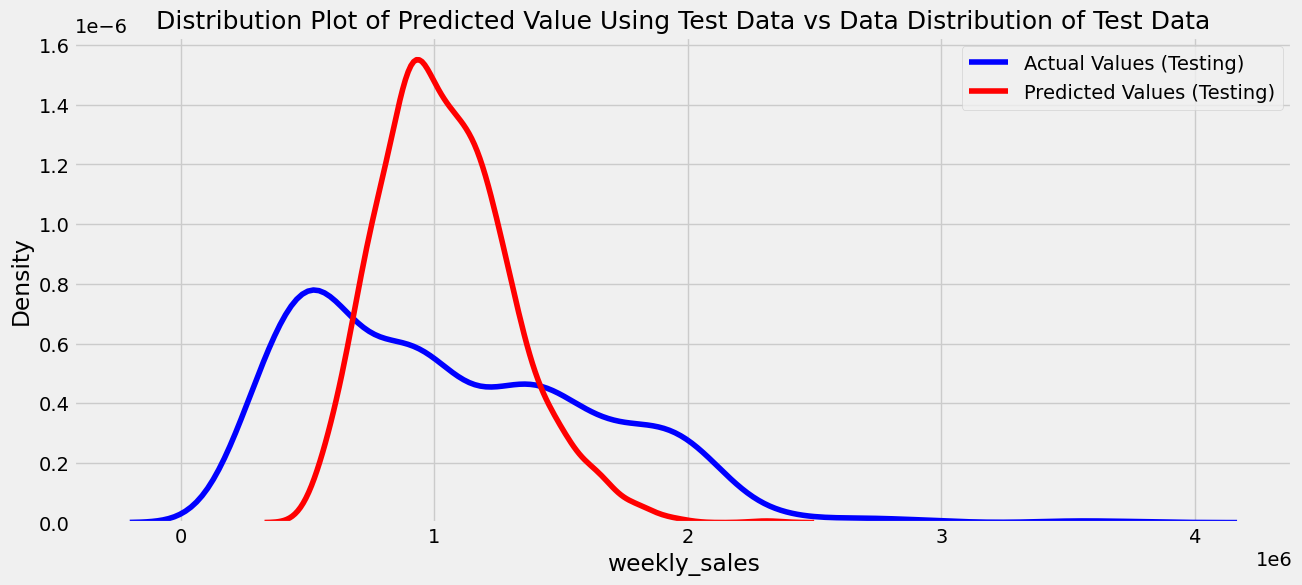

In [111]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_KNN, 'Testing', X_test_transformed, y_test, Title)

In [ ]:
# Conclusion:

  # After testing the KNN Regressor model, it became clear that it is a bad model with an accuracy of 45.37 % in comparison to the above algorithm we used (Linear Regression).

In [ ]:
# 3. Decision Tree Regressor

In [ ]:
 # 3.1. Creating The Model

In [112]:
# Decision Tree regressor Model
tree = DecisionTreeRegressor()

# Fitting the training data
tree.fit(X_train_transformed, y_train)

DecisionTreeRegressor()

In [ ]:
 # 3.2. Evaluating The Model (Training)

In [113]:
# Training Accuracy
model_evaluation(tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 0.0
-> R-Squere score Training: 100.0 % 



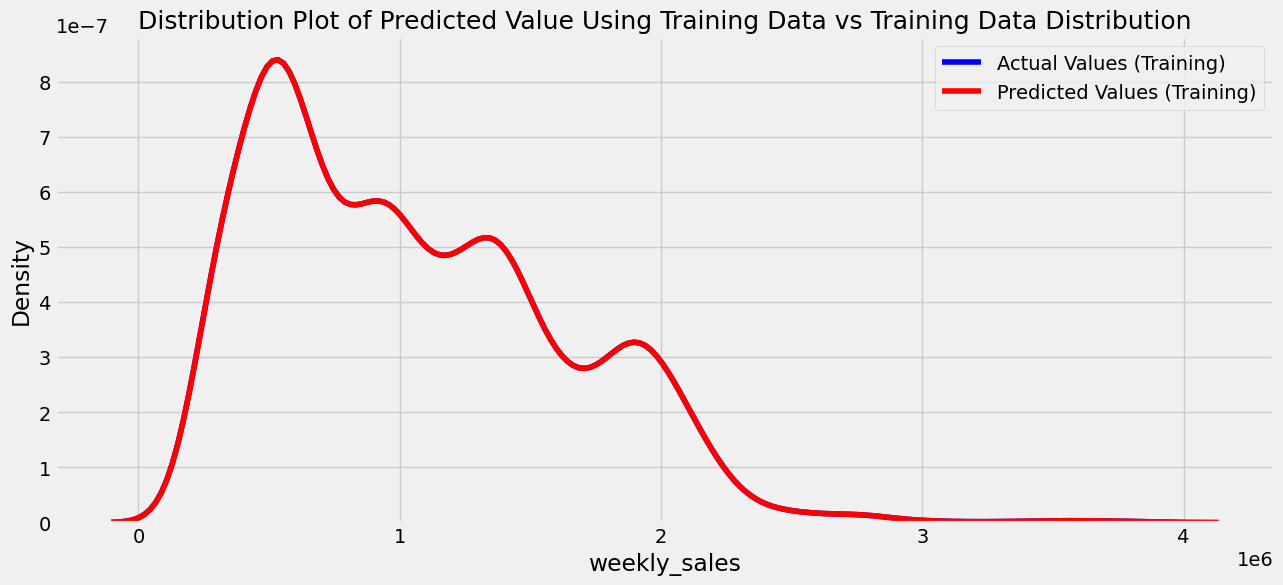

In [114]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(tree, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

  # The model has overfitting, so let's improve it by tuning the hyperparameters..

In [ ]:
 # 3.3. Tuning The Model

In [115]:
# Define the parameter grid to search
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

best_estimator = hyperparameter_tunning(tree, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_Tree = best_estimator

Best parameters: {'max_depth': 13, 'min_samples_split': 40} 

Best score: 0.9224881455940277


In [ ]:
 # 3.4. Evaluating The Model After Tuning

In [116]:
# Training Accuracy Afer tuning
model_evaluation(Best_Tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 130807.75
-> R-Squere score Training: 94.73 % 



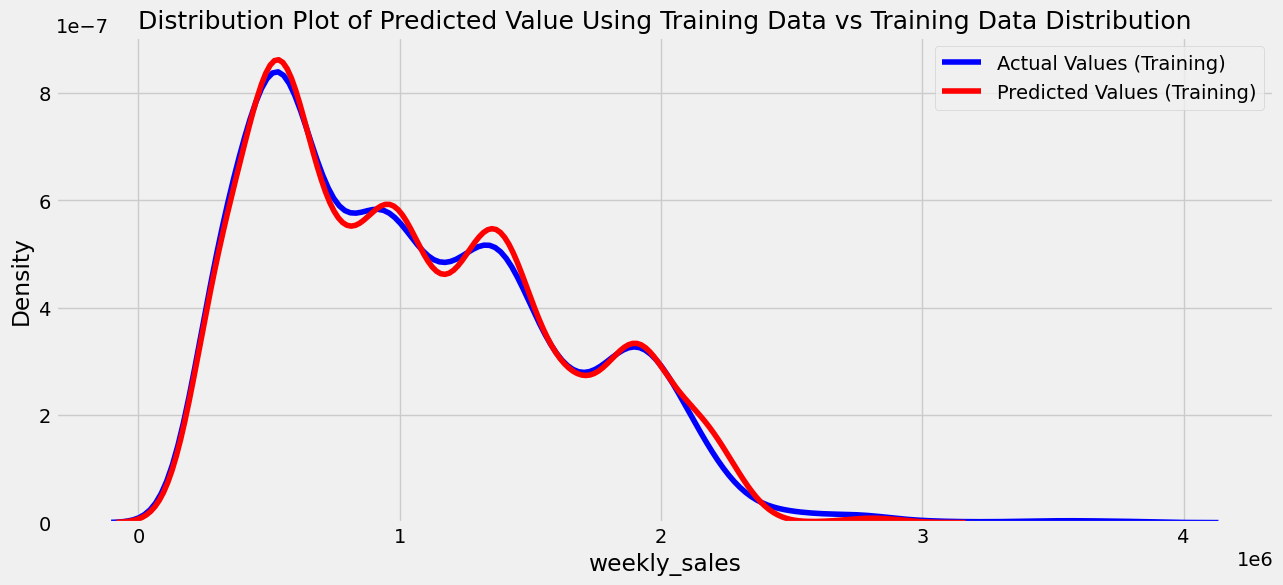

In [117]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_Tree, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

  # After tuning the hyperparameter of max_depth and min_samples_split, The model seems to have improved well in learning from the training dataset.

In [ ]:
 # 3.5. Cross Validation Score

In [118]:
cross_validation_score(Best_Tree, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.92331021 0.93023956 0.93961036 0.88562451 0.9206662  0.92710694
 0.94882773 0.93014782 0.88860554 0.92515003] 

Mean of Scores: 92.19 % 

Standard Deviation of Scores: 0.019083878302660513


In [ ]:
 # 3.6. Testing The Model

In [119]:
# Testing Accuracy
model_evaluation(Best_Tree, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 152245.33
-> R-Squere score Training: 92.91 % 



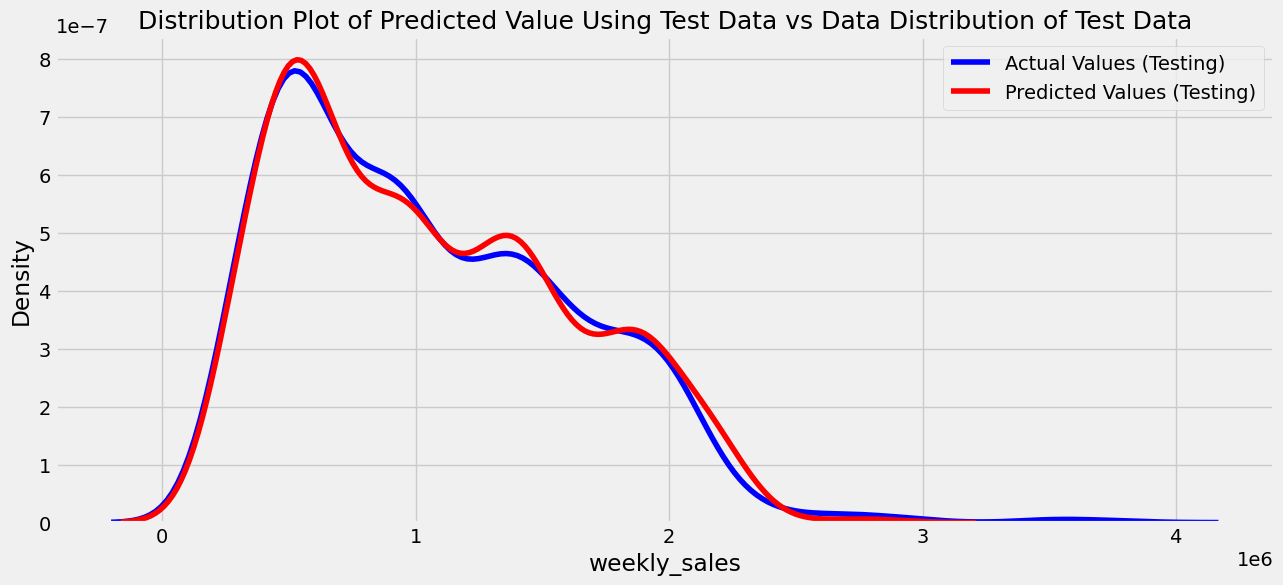

In [120]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_Tree, 'Testing', X_test_transformed, y_test, Title)

In [ ]:
# Conclusion:

 # After testing the Decision Tree Regressor model, it became clear that it is the best model with an accuracy of 92.94 % compared to the above algorithms we used (KNN).

In [ ]:
# 4. Random Forest Regressor (Bagging)

In [ ]:
 # 4.1. Creating The Model

In [121]:
# Random Forest regressor Model
rf = RandomForestRegressor()

# Fitting the training data
rf.fit(X_train_transformed, y_train)

RandomForestRegressor()

In [ ]:
 # 4.2. Evaluating The Model (Training)

In [122]:
# Training Accuracy
model_evaluation(rf, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 50491.8
-> R-Squere score Training: 99.22 % 



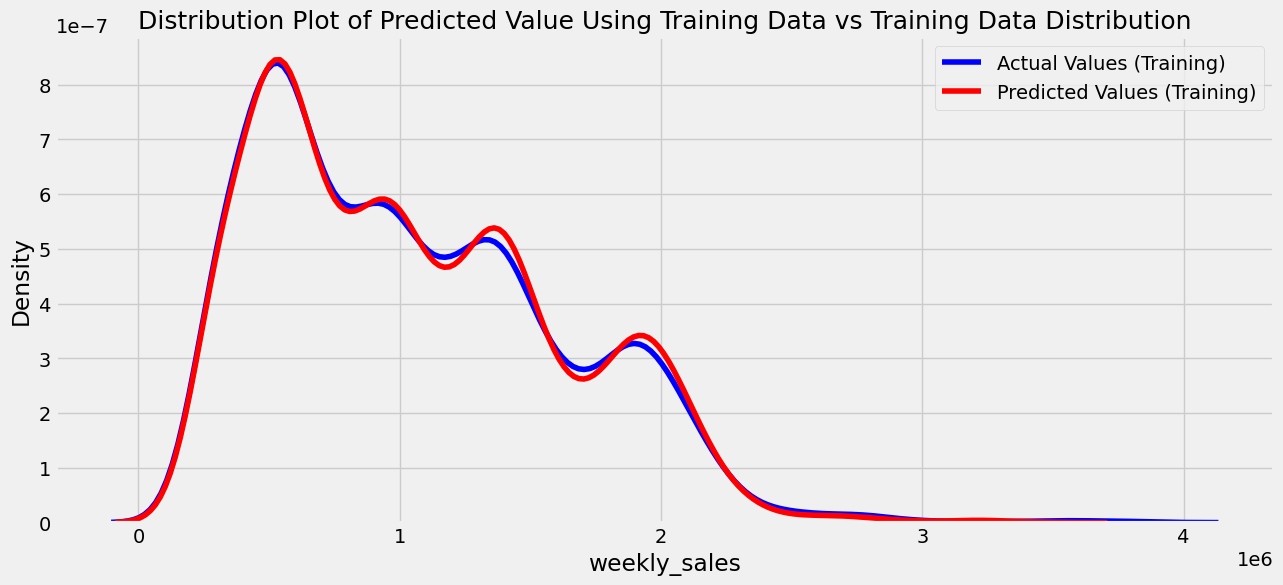

In [123]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(rf, 'Training', X_train_transformed, y_train, Title)

In [ ]:
# Conclusion:

 # Has the model been overfitted?! let's be sure of that by doing a cross-validation score.

In [ ]:
 # 4.3. Cross Validation Score

In [124]:
cross_validation_score(rf, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.94946131 0.94488104 0.96186522 0.89989727 0.92528244 0.9463115
 0.96258358 0.9486938  0.92803335 0.94003483] 

Mean of Scores: 94.07 % 

Standard Deviation of Scores: 0.017832385598740088


In [ ]:
# Conclusion:

 # After doing a cross-validation score, we see the model has trained very well.

In [ ]:
 # 4.4. Testing The Model

In [125]:
# Testing Accuracy
model_evaluation(rf, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 124893.5
-> R-Squere score Training: 95.23 % 



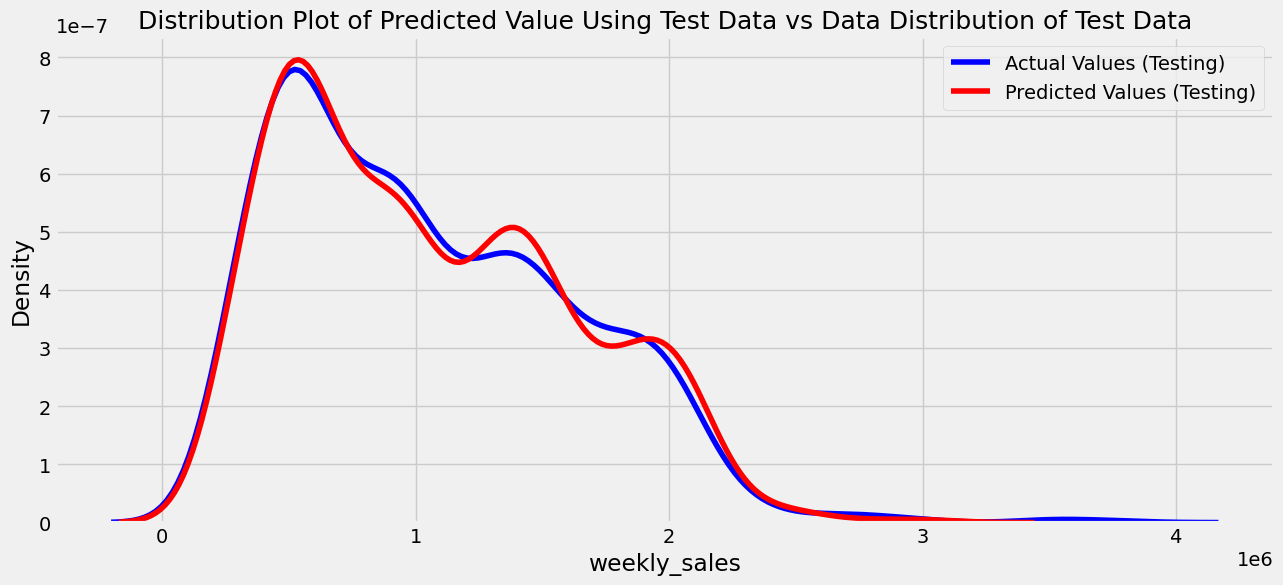

In [126]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(rf, 'Testing', X_test_transformed, y_test, Title)

In [ ]:
# Conclusion:

 # After testing the Random Forest Regressor model, it became clear that it is the best model with an accuracy of 94.76 % compared to the above algorithms we used (e.g. KNN, and Decision Tree Regressor).

In [ ]:
# Decision Making: Determining a Good Model Fit: 


# Now that we have visualized the different models, and generated the R-squared and MSE values for the fits, how do we determine a good model fit?

# What is a good R-squared value?
  # When comparing models, the model with the higher R-squared value is a better fit for the data.

# What is a good MSE?
  # When comparing models, the model with the smallest MSE value is a better fit for the data.

    
# Let's take a look at the values for the different models.

   # Linear Regression:
     # 1. R-squared: 96.84 %
     # 2. RMSE: 101730.35
    
   #  KNN Regressor:
     # 1. R-squared: 45.37 %
     # 2. RMSE: 422689.74

   #  Decision Tree Regressor:
     # 1. R-squared: 92.94 %
     # 2. RMSE: 151915.04
    
   #  Random Forest Regressor:
     # 1. R-squared: 94.76 %
     # 2. RMSE: 130846.43

In [ ]:
# Conclusions : 

  # 1. Sales tend to be higher in Summer.

  # 2. The rate of sales on holidays is higher than on other days.

  # 3. There is a high variance in weekly sales from one store to another.

  # 4. Sales are affected by the unemployment rate, so the higher the unemployment rate, the lower the sales.

  # 5. Comparing these four models, we conclude that The Linear Regression Model is the best model with an accuracy of 96.84 % to be able to predict weekly sales from our dataset